# Early Breast Cancer Prediction — Polished End‑to‑End Notebook


This notebook is organized for a clean, step‑by‑step presentation with simple code cells and clear visuals.

**Outline**
1. Setup & Configuration  
2. Load Data (10% sample)  
3. Exploratory Data Analysis (EDA)  
   - 3.1 Structure & dtypes  
   - 3.2 Missingness  
   - 3.3 Class balance  
   - 3.4 Numeric distributions  
   - 3.5 Correlations  
4. Feature Engineering  
5. Preprocessing & Train/Test Split (leakage‑safe)  
6. Baseline Model — Logistic Regression  
7. Additional Models — RF, GB, XGB, CatBoost, SVM, KNN, Naive Bayes (quick baselines)  
8. Hyperparameter Tuning (per model) → `*_best`  
9. Model Comparison (hold‑out)  
10. Ensembles (Voting + Balanced Bagging)  
11. OOF‑based Thresholding (unbiased)  
12. Calibration & Reliability Diagram  
13. PR/ROC Curves (combined)  
14. Explainability (SHAP + fallback)  
15. Final Predictions & Auto Report


## 1) Setup & Configuration

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt

import os, warnings
os.environ.pop("PYTHONWARNINGS", None)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


warnings.resetwarnings()
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Early stopping criterion not reached")
warnings.filterwarnings("ignore", message="use of fork")
warnings.filterwarnings("ignore", message="No child processes")
warnings.filterwarnings("ignore", message="This process", category=DeprecationWarning)
warnings.filterwarnings(
    "ignore",
    message="use of fork() may lead to deadlocks",
    category=DeprecationWarning
)


from joblib import parallel_backend
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import inspect
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline as SkPipeline

# Paths
#DATA_PATH = "sample_10percent.csv"  # develop on the 10% sample
DATA_PATH = "bcsc_risk_factors.csv"  # develop on the 10% sample
# Reproducibility
RANDOM_STATE = 42

# Plot defaults (matplotlib only, one chart per cell)
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

## 2) Load Data (10% sample)

In [2]:
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
display(df.head(5))

Loaded shape: (1522340, 13)


year  age_group_5_years  race_eth  first_degree_hx  age_menarche  \
0  2005                  1         1                0             0   
1  2005                  1         1                0             0   
2  2005                  1         1                0             0   
3  2005                  1         1                0             0   
4  2005                  1         1                0             0   

   age_first_birth  BIRADS_breast_density  current_hrt  menopaus  bmi_group  \
0                0                      2            0         1          9   
1                0                      4            0         1          1   
2                0                      4            0         1          2   
3                0                      4            0         1          9   
4                1                      4            0         1          4   

   biophx  breast_cancer_history  count  
0       0                      0      2  
1       0                      0      1  
2       0                      0      1  
3       0                      0      2  
4       0                      0      1

## 3) Exploratory Data Analysis (EDA)

### 3.1 Structure & dtypes

In [3]:

display(df.info())
display(df.describe)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522340 entries, 0 to 1522339
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype
---  ------                 --------------    -----
 0   year                   1522340 non-null  int64
 1   age_group_5_years      1522340 non-null  int64
 2   race_eth               1522340 non-null  int64
 3   first_degree_hx        1522340 non-null  int64
 4   age_menarche           1522340 non-null  int64
 5   age_first_birth        1522340 non-null  int64
 6   BIRADS_breast_density  1522340 non-null  int64
 7   current_hrt            1522340 non-null  int64
 8   menopaus               1522340 non-null  int64
 9   bmi_group              1522340 non-null  int64
 10  biophx                 1522340 non-null  int64
 11  breast_cancer_history  1522340 non-null  int64
 12  count                  1522340 non-null  int64
dtypes: int64(13)
memory usage: 151.0 MB


None

<bound method NDFrame.describe of          year  age_group_5_years  race_eth  first_degree_hx  age_menarche  \
0        2005                  1         1                0             0   
1        2005                  1         1                0             0   
2        2005                  1         1                0             0   
3        2005                  1         1                0             0   
4        2005                  1         1                0             0   
...       ...                ...       ...              ...           ...   
1522335  2017                 13         9                9             9   
1522336  2017                 13         9                9             9   
1522337  2017                 13         9                9             9   
1522338  2017                 13         9                9             9   
1522339  2017                 13         9                9             9   

         age_first_birth  BIRADS_breast_d

In [4]:
df.describe()

year  age_group_5_years      race_eth  first_degree_hx  \
count  1.522340e+06       1.522340e+06  1.522340e+06     1.522340e+06   
mean   2.010890e+03       7.299497e+00  2.659045e+00     7.925976e-01   
std    3.663113e+00       2.552748e+00  2.276457e+00     2.082614e+00   
min    2.005000e+03       1.000000e+00  1.000000e+00     0.000000e+00   
25%    2.008000e+03       5.000000e+00  1.000000e+00     0.000000e+00   
50%    2.011000e+03       7.000000e+00  2.000000e+00     0.000000e+00   
75%    2.014000e+03       9.000000e+00  3.000000e+00     1.000000e+00   
max    2.017000e+03       1.300000e+01  9.000000e+00     9.000000e+00   

       age_menarche  age_first_birth  BIRADS_breast_density   current_hrt  \
count  1.522340e+06     1.522340e+06           1.522340e+06  1.522340e+06   
mean   4.587934e+00     3.543348e+00           3.219309e+00  1.934484e+00   
std    4.046724e+00     3.150968e+00           2.265064e+00  3.610054e+00   
min    0.000000e+00     0.000000e+00           1.000000e+00  0.000000e+00   
25%    1.000000e+00     1.000000e+00           2.000000e+00  0.000000e+00   
50%    2.000000e+00     3.000000e+00           3.000000e+00  0.000000e+00   
75%    9.000000e+00     4.000000e+00           3.000000e+00  1.000000e+00   
max    9.000000e+00     9.000000e+00           9.000000e+00  9.000000e+00   

           menopaus     bmi_group        biophx  breast_cancer_history  \
count  1.522340e+06  1.522340e+06  1.522340e+06           1.522340e+06   
mean   2.635728e+00  4.261685e+00  7.441419e-01           2.101958e+00   
std    2.311327e+00  3.243548e+00  1.789292e+00           3.651569e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00           0.000000e+00   
25%    2.000000e+00  2.000000e+00  0.000000e+00           0.000000e+00   
50%    2.000000e+00  3.000000e+00  0.000000e+00           0.000000e+00   
75%    2.000000e+00  9.000000e+00  1.000000e+00           1.000000e+00   
max    9.000000e+00  9.000000e+00  9.000000e+00           9.000000e+00   

              count  
count  1.522340e+06  
mean   4.459211e+00  
std    1.880898e+01  
min    1.000000e+00  
25%    1.000000e+00  
50%    1.000000e+00  
75%    3.000000e+00  
max    2.684000e+03

### 3.2 Missingness

In [5]:

missing = df.isna().mean().sort_values(ascending=False)
print("Top 30 missingness:")
display(missing.head(30))
plt.figure()
missing.head(30).plot(kind='bar')
plt.title('Top 30 Missingness (fraction)')
plt.ylabel('Fraction')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Top 30 missingness:


year                     0.0
age_group_5_years        0.0
race_eth                 0.0
first_degree_hx          0.0
age_menarche             0.0
age_first_birth          0.0
BIRADS_breast_density    0.0
current_hrt              0.0
menopaus                 0.0
bmi_group                0.0
biophx                   0.0
breast_cancer_history    0.0
count                    0.0
dtype: float64

### 3.3 Class balance

In [6]:
rename_map = {
    "age_group_5_years": "age",
    "race_eth": "race",
    "first_degree_hx": "family_history",
    "age_menarche": "menarche",
    "age_first_birth": "first_birth",
    "BIRADS_breast_density": "breast",
    "current_hrt": "hormone_therapy",
    "menopaus": "menopause",
    "bmi_group": "bmi",
    "biophx": "biopsy",
    "breast_cancer_history": "cancer"
}

df = df.rename(columns=rename_map)

In [7]:

# Identify/confirm target
TARGET_COL = 'cancer' if 'cancer' in df.columns else df.columns[-1]
pos = int(df[TARGET_COL].sum())
neg = int((df[TARGET_COL]==0).sum())
print(f"Target: {TARGET_COL} | Positives: {pos} | Negatives: {neg} | Pos rate: {pos/(pos+neg):.4f}")


Target: cancer | Positives: 3199894 | Negatives: 969662 | Pos rate: 0.7674


In [8]:
vc = df["cancer"].value_counts().sort_index()
print("Counts:\n", vc)
print("\nPercentages:\n", (vc / len(df) * 100).round(2))

Counts:
 cancer
0    969662
1    221776
9    330902
Name: count, dtype: int64

Percentages:
 cancer
0    63.70
1    14.57
9    21.74
Name: count, dtype: float64


### 3.4 Numeric distributions

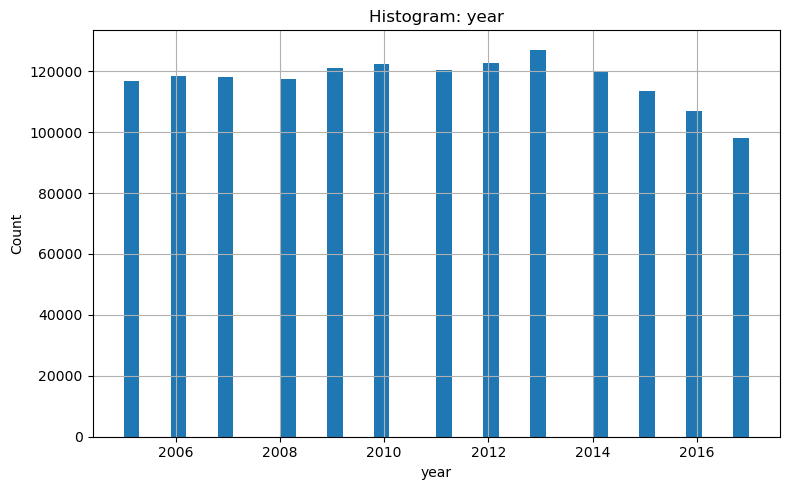

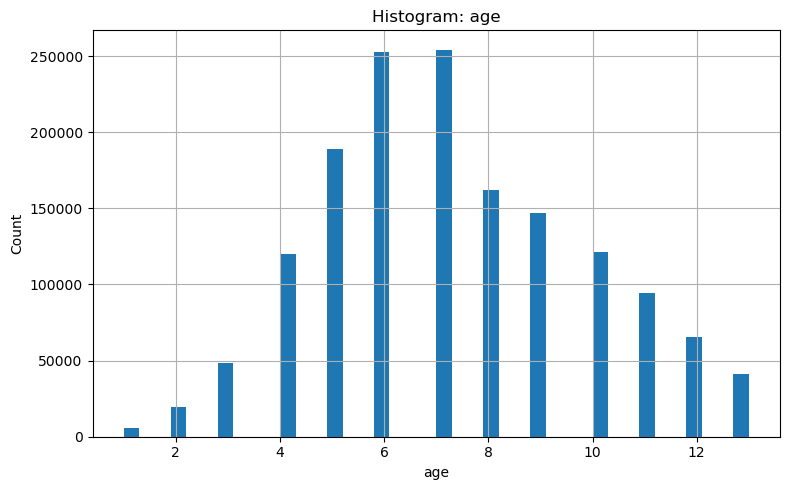

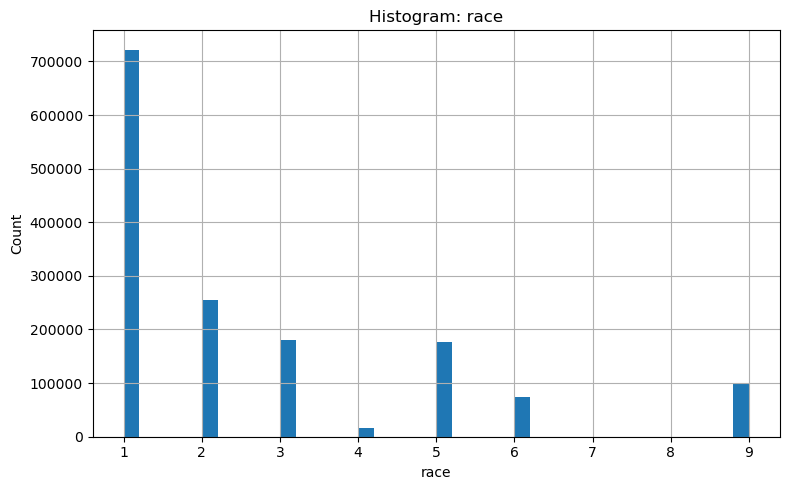

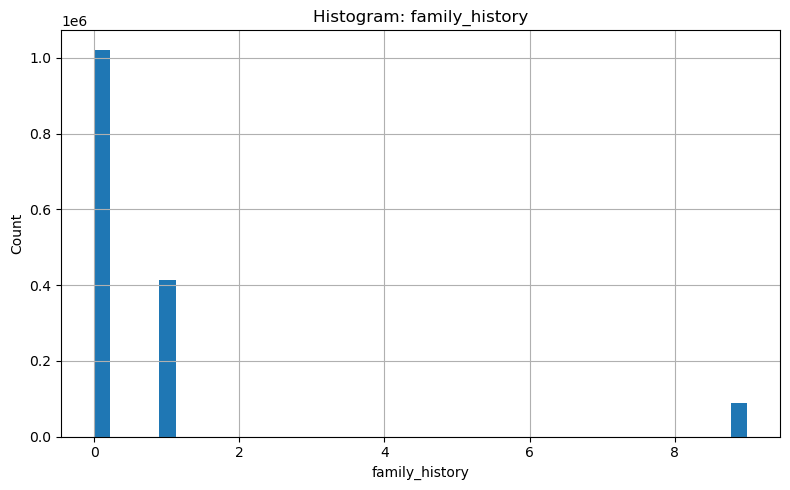

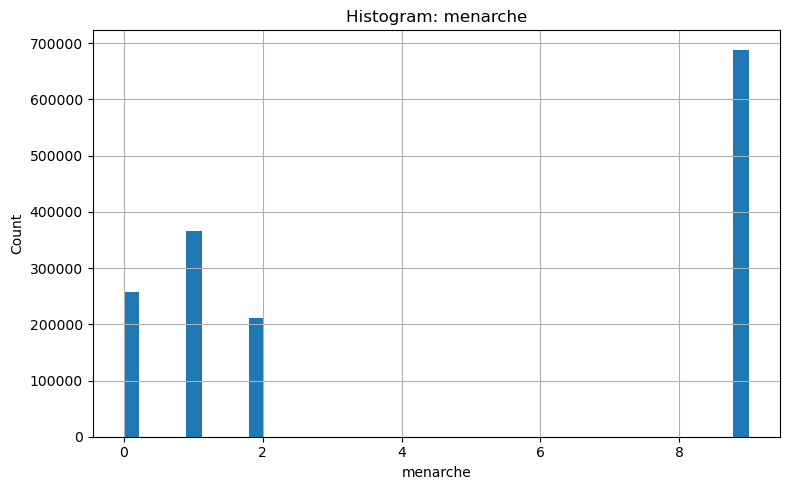

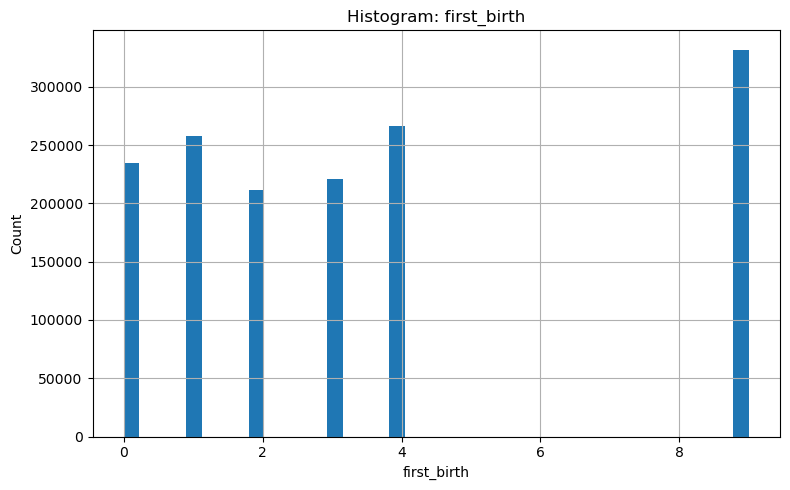

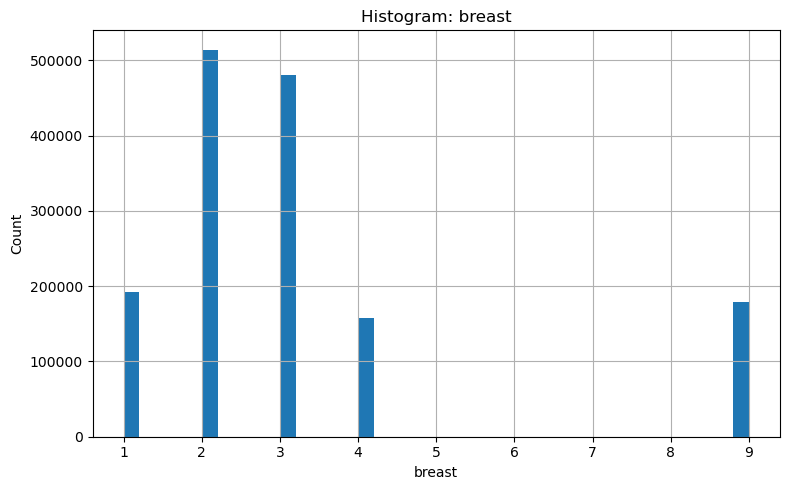

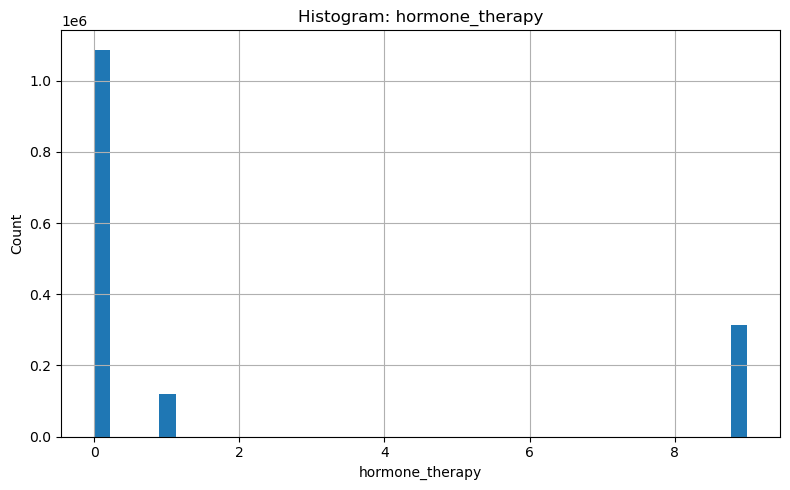

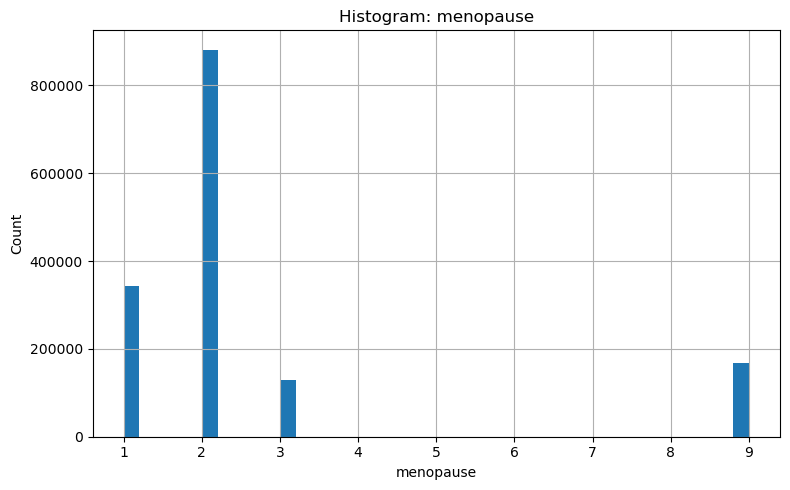

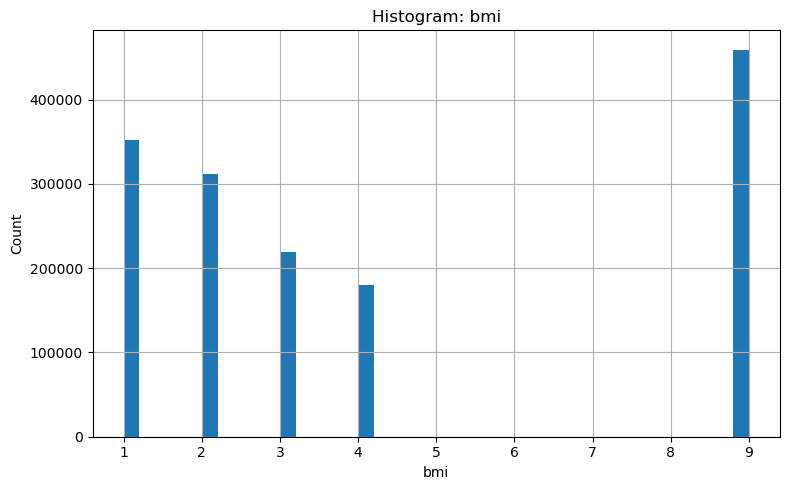

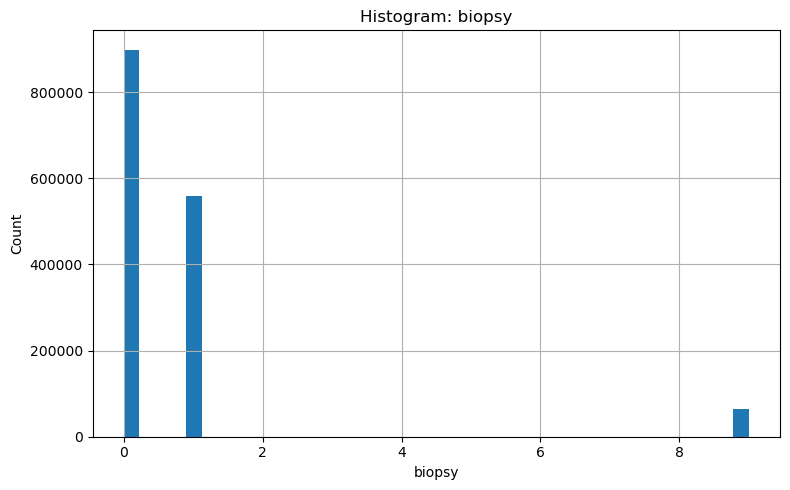

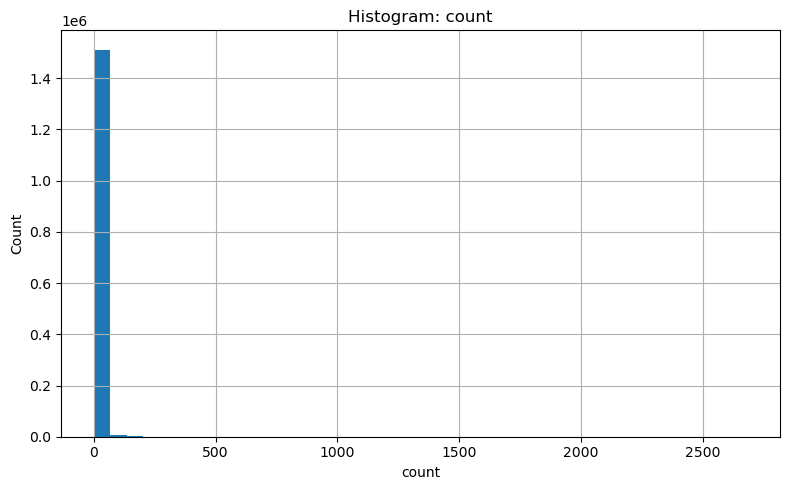

In [9]:

numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
plot_cols = [c for c in numeric_cols_all if c != TARGET_COL][:12]
for col in plot_cols:
    plt.figure()
    s = df[col].dropna()
    plt.hist(s, bins=40)
    plt.title(f'Histogram: {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.tight_layout(); plt.show()


### 3.5 Correlations (numeric)

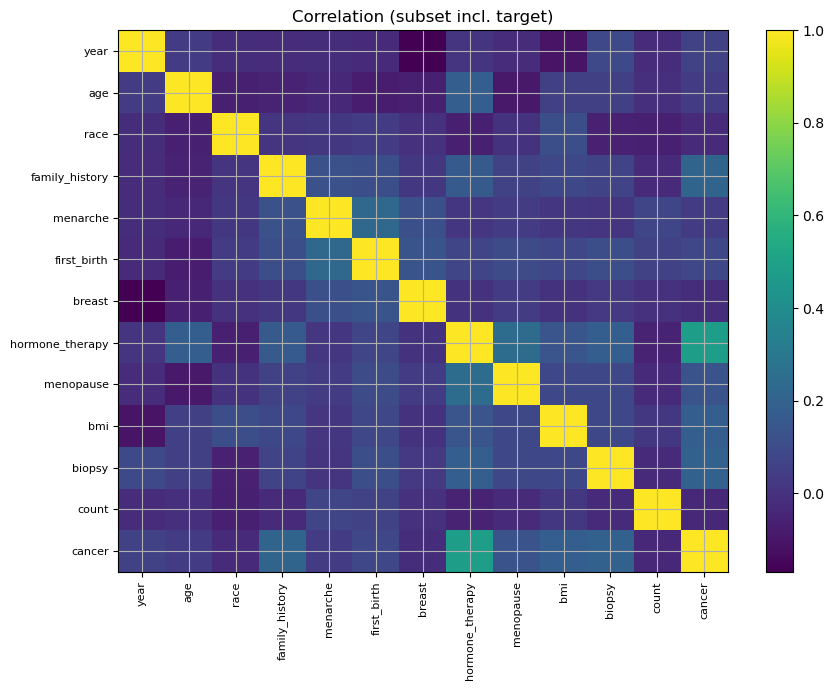

In [10]:

corr_cols = [c for c in numeric_cols_all if c != TARGET_COL][:25] + [TARGET_COL]
corr = df[corr_cols].corr().values
labels = corr_cols
plt.figure(figsize=(9,7))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title('Correlation (subset incl. target)')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90, fontsize=8)
plt.yticks(range(len(labels)), labels, fontsize=8)
plt.tight_layout(); plt.show()


In [11]:
df.groupby("cancer").mean().T.style.highlight_max(subset = None,
                                                       color = 'yellow',
                                                       axis = 1, props = None)

###  EDA Visualizations

In [12]:
df.groupby("cancer").mean()[["age", "family_history", "bmi"]].T

cancer                 0         1         9
age             7.018283  8.393834  7.390112
family_history  0.556207  0.609624  1.607938
bmi             3.824753  4.592693  5.320204

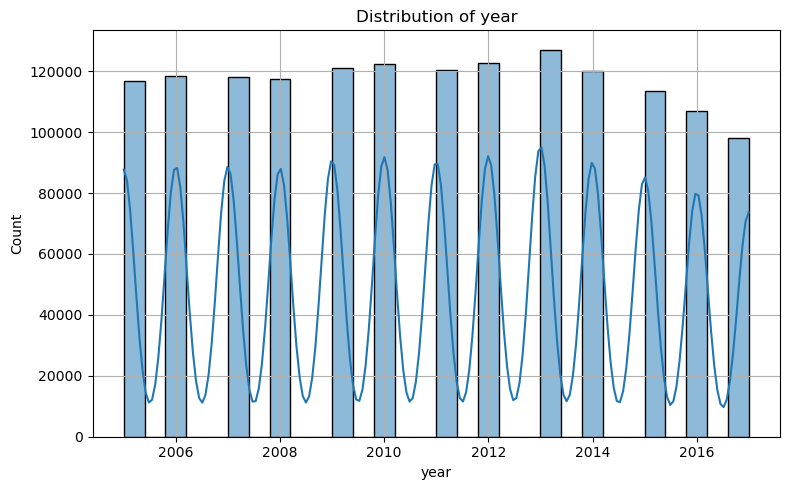

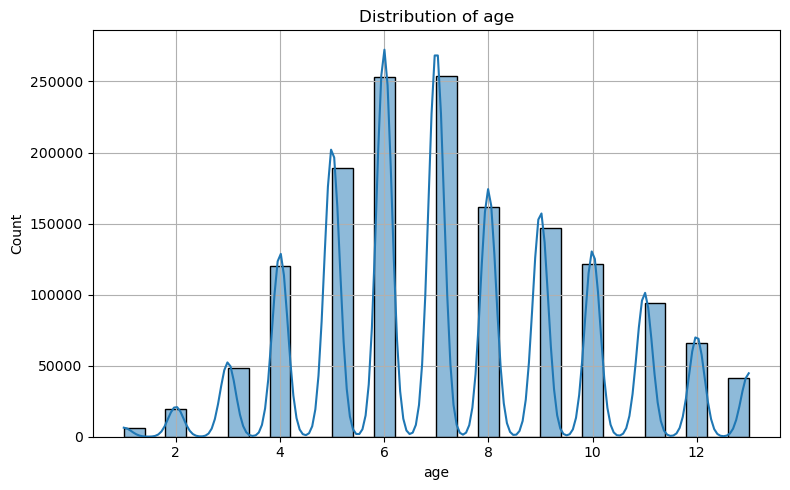

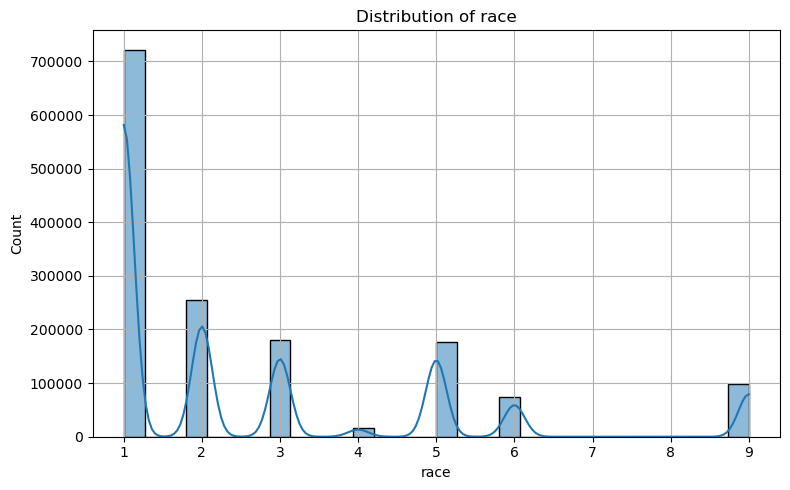

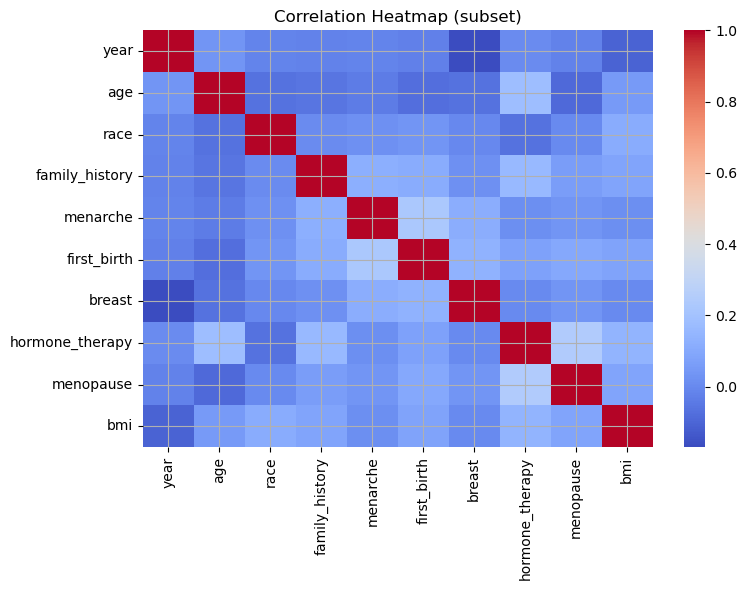

In [13]:
# Additional EDA Visualizations

import seaborn as sns

# 1. Missingness bar chart for top 20 columns
missing = df.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
missing.head(5).plot(kind='bar')
plt.title('Top 20 Columns by Missingness')
plt.ylabel('Fraction Missing')
plt.tight_layout()
plt.savefig('missingness_bar.png')
plt.show()

# 2. Numeric distributions for selected columns
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
for col in numeric_cols[:3]:  # show first 3 distributions
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig(f'dist_{col}.png')
    plt.show()

# 3. Correlation heatmap (subset)
corr_cols = [c for c in numeric_cols][:10]  # limit to 10 features for readability
corr = df[corr_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (subset)')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

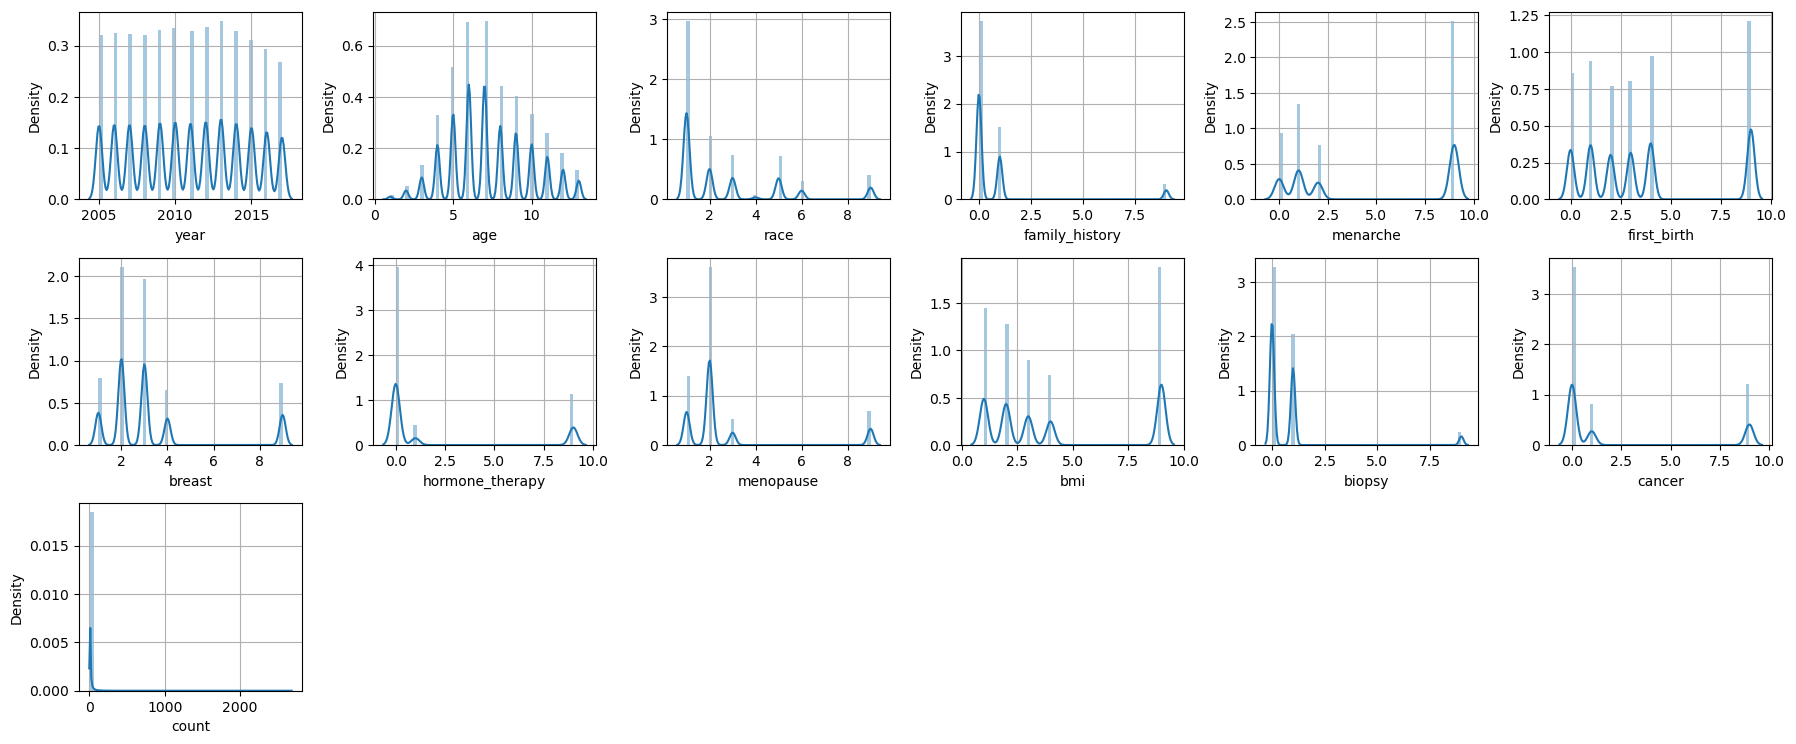

In [14]:
plt.figure(figsize = (18, 12))
plotnumber = 1

for column in df:
    if plotnumber <= 20:
        ax = plt.subplot(5, 6, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

## 4) Feature Engineering

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522340 entries, 0 to 1522339
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   year             1522340 non-null  int64
 1   age              1522340 non-null  int64
 2   race             1522340 non-null  int64
 3   family_history   1522340 non-null  int64
 4   menarche         1522340 non-null  int64
 5   first_birth      1522340 non-null  int64
 6   breast           1522340 non-null  int64
 7   hormone_therapy  1522340 non-null  int64
 8   menopause        1522340 non-null  int64
 9   bmi              1522340 non-null  int64
 10  biopsy           1522340 non-null  int64
 11  cancer           1522340 non-null  int64
 12  count            1522340 non-null  int64
dtypes: int64(13)
memory usage: 151.0 MB


In [16]:
df = df[df["cancer"] != 9]

In [17]:
# AGE midpoint proxy
age = df['age'].astype('int64')
age_mid = {1:23.5,2:32.0,3:37.0,4:42.0,5:47.0,6:52.0,7:57.0,8:62.0,9:67.0,10:72.0,11:77.0,12:82.0,13:87.0}
df['age_proxy'] = age.map(age_mid).astype(float)

# BMI midpoint proxy
bmi = df['bmi'].astype('int64')
bmi_mid = {1:22.5, 2:27.5, 3:32.5, 4:37.5, 9:np.nan}
df['bmi_proxy'] = bmi.map(bmi_mid).astype(float)

# Missingness is information
df["is_bmi_missing"] = df["bmi_proxy"].isna().astype(int)

In [18]:
df['first_birth'].unique()

array([0, 1, 2, 4, 9, 3])

In [19]:
df["menopause"].unique()

array([1, 2, 9, 3])

In [20]:
df["biopsy_yes"] = (df["biopsy"] == 1).astype(int)     # 1 if biopsy==1 else 0
df["biopsy_unk"] = (df["biopsy"] == 9).astype(int)     # 1 if biopsy==9 else 0

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191438 entries, 0 to 1522339
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   year             1191438 non-null  int64  
 1   age              1191438 non-null  int64  
 2   race             1191438 non-null  int64  
 3   family_history   1191438 non-null  int64  
 4   menarche         1191438 non-null  int64  
 5   first_birth      1191438 non-null  int64  
 6   breast           1191438 non-null  int64  
 7   hormone_therapy  1191438 non-null  int64  
 8   menopause        1191438 non-null  int64  
 9   bmi              1191438 non-null  int64  
 10  biopsy           1191438 non-null  int64  
 11  cancer           1191438 non-null  int64  
 12  count            1191438 non-null  int64  
 13  age_proxy        1191438 non-null  float64
 14  bmi_proxy        881757 non-null   float64
 15  is_bmi_missing   1191438 non-null  int64  
 16  biopsy_yes       119143

### Feature Engineering Visualizations
Visualize engineered feature distributions.

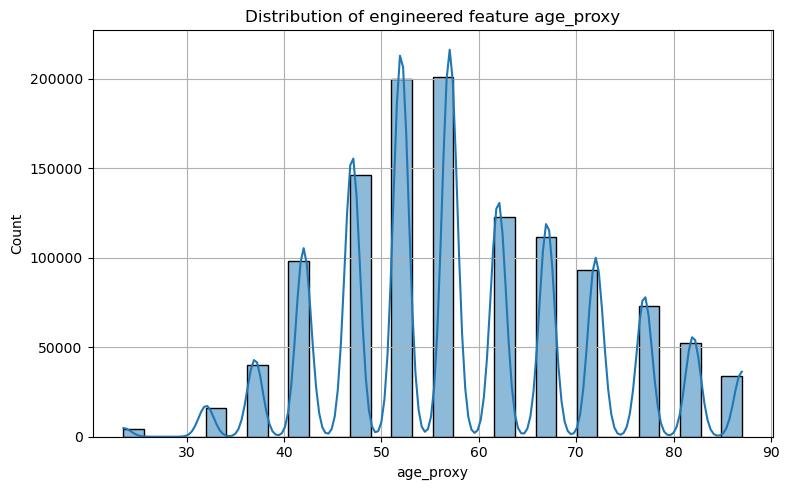

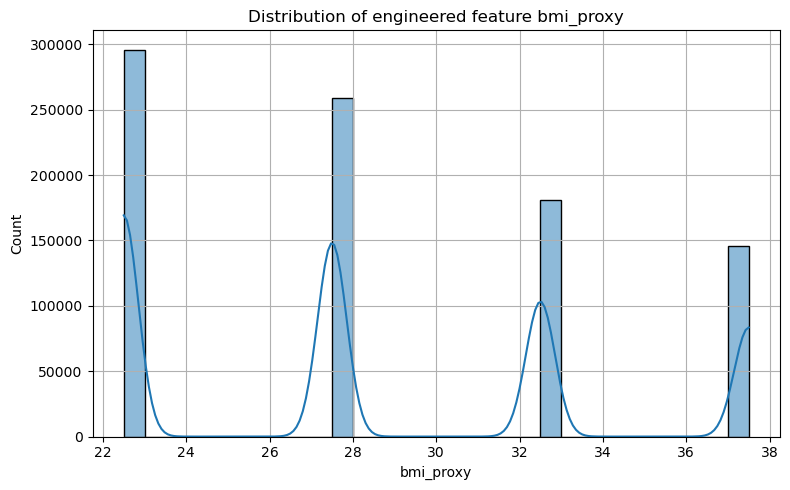

In [22]:
# Feature Engineering Visualizations

import seaborn as sns

engineered_cols = [
    "age_proxy","bmi_proxy","age_menarche","age_first_birth","nulliparous",
    "years_since_first_birth","reproductive_span","menarche_meno_gap",
    "is_bmi_missing","biopsy_yes","biopsy_unk"
]
for col in engineered_cols[:5]:
    if col in df.columns:
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of engineered feature {col}')
        plt.tight_layout()
        plt.savefig(f'feat_{col}.png')
        plt.show()


Transformubg unknown from cols, to .nan.

In [23]:
UNK9_COLS = [
    "race","family_history","menarche","first_birth",
    "breast","hormone_therapy","menopause","bmi",
    "biopsy", TARGET_COL
]
df[UNK9_COLS] = df[UNK9_COLS].replace(9, np.nan)

In [24]:
NUMERIC_COLS = [
    "year",
    "age",
    "race",
    "family_history",
    "first_birth",
    "hormone_therapy",
    "menopause",
    "age_proxy",
    "bmi_proxy",
    "is_bmi_missing",
    "biopsy_yes",
    "biopsy",
    "biopsy_unk"
]

ORDINAL_COLS = [              # 1–13 (older -> higher)
    "menarche",                   # 0=>14,1=12–13,2=<12  (younger -> higher)               # 0:<20,1:20–24,2:25–29,3:≥30,4:nulliparous
    "breast",          # 1–4 (denser -> higher)
    "bmi"                       # 0/1
]


In [25]:
df['cancer'].unique()

array([0, 1])

<Axes: >

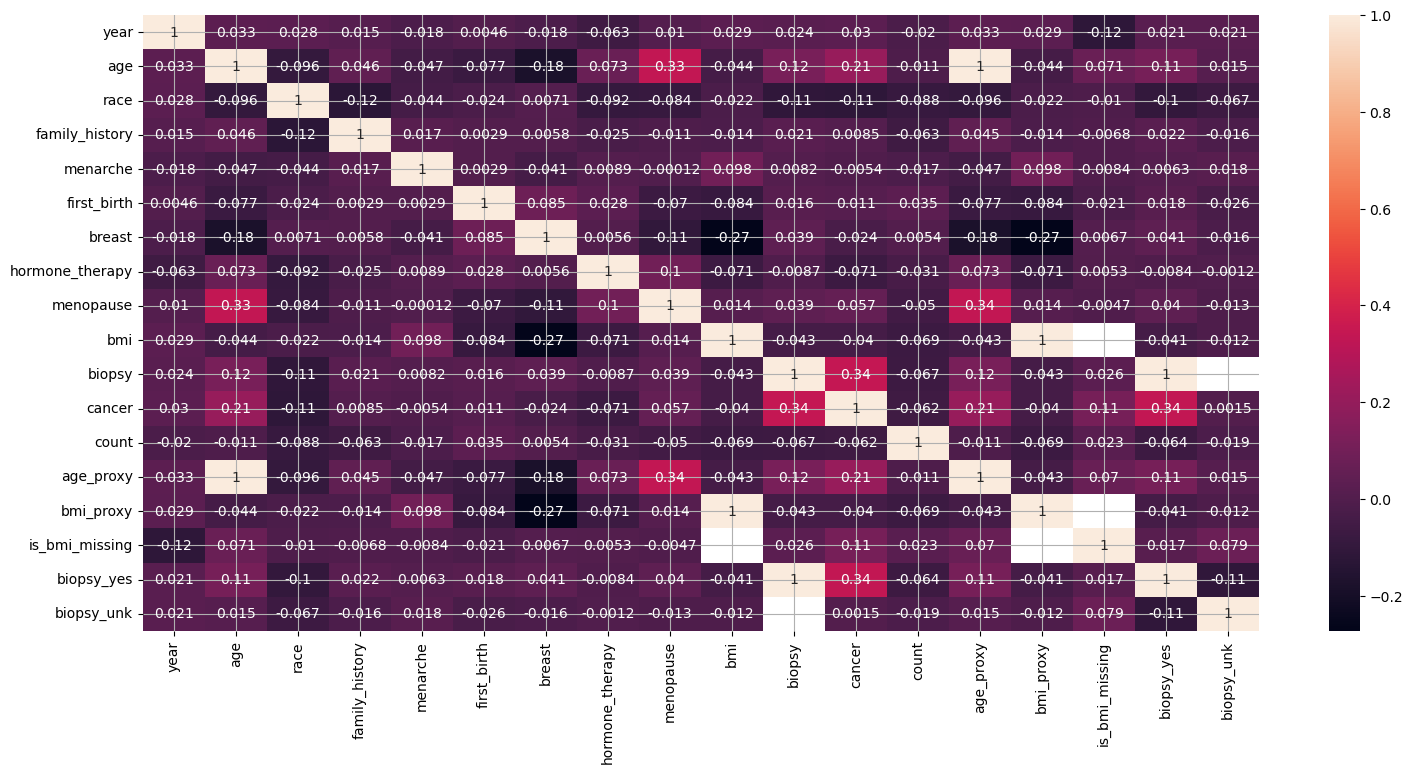

In [26]:
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(), annot=True)

#### Sample Fraction

In [27]:
SAMPLE_FRAC   = 0.10  

if 0 < SAMPLE_FRAC < 1:
    df = (df
          .groupby(TARGET_COL, group_keys=False)
          .apply(lambda x: x.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE))
          .reset_index(drop=True))
    print(f"Using stratified sample: {len(df):,} rows (frac={SAMPLE_FRAC:.0%})")
else:
    print("SAMPLE_FRAC not in (0,1); using full dataset.")

Using stratified sample: 119,144 rows (frac=10%)


## 5) Preprocessing & Train/Test Split (leakage‑safe)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline

X = df.drop(columns=[TARGET_COL,'count'])
y = df[TARGET_COL].astype(int)

# baseline weights: population counts
w_all = df['count'].astype(float).copy()

# compute class weights based on inverse class frequencies
n_samples = len(y)
n_pos = int(y.sum())
n_neg = n_samples - n_pos

if n_pos == 0 or n_neg == 0:
    class_weight_0 = 1.0
    class_weight_1 = 1.0
else:
    class_weight_0 = n_samples / (2.0 * n_neg)
    class_weight_1 = n_samples / (2.0 * n_pos)

# apply class weights
w_all = w_all * np.where(y == 1, class_weight_1, class_weight_0)

# normalise mean weight to 1
w_all = w_all * (len(w_all) / np.sum(w_all))

# split data into train and test sets; stratify and carry weights along
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w_all, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

In [29]:
num_tf = SkPipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])

ord_tf = SkPipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer([('num', num_tf, NUMERIC_COLS),
                                  ('ord', ord_tf, ORDINAL_COLS)], remainder='drop', verbose_feature_names_out=False
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (95315, 16) Test: (23829, 16)


In [30]:
# keep as Series/DataFrame but make their indices 0..n-1
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test  = pd.Series(y_test).reset_index(drop=True)

w_train = pd.Series(w_train).reset_index(drop=True)
w_test  = pd.Series(w_test).reset_index(drop=True)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, w_train.shape, w_test.shape

((95315, 16), (23829, 16), (95315,), (23829,), (95315,), (23829,))

In [32]:
# ========= Enhanced evaluation utilities =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score, roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)

# global store for model rows
EVAL_ROWS = []

def _confusion_parts(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    return cm, tn, fp, fn, tp, sens, spec, prec, rec, f1

def evaluate_holdout(
    name, fitted_pipe, X, y, *,
    threshold=0.65, weight_vector=None,
    plot_curves=True, plot_cms=True, store=True
):
    
    # --- probabilities or decision function
    if hasattr(fitted_pipe, "predict_proba"):
        proba = fitted_pipe.predict_proba(X)[:, 1]
    else:
        proba = fitted_pipe.decision_function(X)
        # map to (0,1) if needed: proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-9)

    # --- AUC metrics (unweighted by default; pass weight_vector if you want population-weighted)
    pr_auc  = average_precision_score(y, proba, sample_weight=weight_vector)
    roc_auc = roc_auc_score(y, proba, sample_weight=weight_vector)

    # ---------- Threshold sweeps ----------
    # PR sweep -> best F1
    precisions, recalls, pr_thresholds = precision_recall_curve(y, proba, sample_weight=weight_vector)
    # Note: precision_recall_curve returns thresholds length K-1
    f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
    best_f1_idx = int(np.nanargmax(f1s)) if len(f1s) else 0
    best_f1_th  = float(pr_thresholds[best_f1_idx]) if len(pr_thresholds) else float(threshold)
    best_f1     = float(np.nanmax(f1s)) if len(f1s) else np.nan

    # ROC sweep -> best Youden J = TPR - FPR
    fpr, tpr, roc_thresholds = roc_curve(y, proba, sample_weight=weight_vector)
    youden = tpr - fpr
    best_youden_idx = int(np.argmax(youden))
    best_youden_th  = float(roc_thresholds[best_youden_idx])
    best_youden     = float(np.max(youden))

    # ---------- Metrics at threshold A (given) ----------
    y_pred_A = (proba >= float(threshold)).astype(int)
    cmA, tnA, fpA, fnA, tpA, sensA, specA, precA, recA, f1A = _confusion_parts(y, y_pred_A)

    # ---------- Metrics at threshold B (best F1) ----------
    y_pred_B = (proba >= best_f1_th).astype(int)
    cmB, tnB, fpB, fnB, tpB, sensB, specB, precB, recB, f1B = _confusion_parts(y, y_pred_B)

    # ---------- Pretty print ----------
    print(f"\n===== {name} — HOLDOUT EVALUATION =====")
    print(f"PR-AUC:  {pr_auc:.4f}   |   ROC-AUC: {roc_auc:.4f}")
    print(f"Best-F1 threshold: {best_f1_th:.3f}   (F1={f1B:.4f}, Precision={precB:.4f}, Recall={recB:.4f}, Spec={specB:.4f})")
    print(f"Best-Youden threshold: {best_youden_th:.3f}   (J={best_youden:.4f})")
    print(f"\n-- At threshold {threshold:.2f} --")
    print(f"TP={tpA}  FP={fpA}  TN={tnA}  FN={fnA}")

    # --- new summary section ---
    correct = tpA + tnA
    incorrect = fpA + fnA
    total = correct + incorrect
    accuracy = correct / total if total > 0 else np.nan

    print(f"✅ Correctly classified instances: {correct:,}")
    print(f"❌ Misclassified instances: {incorrect:,}")
    print(f"📊 Total evaluated instances: {total:,}")
    print(f"🎯 Overall accuracy: {accuracy:.4f}")
    
    # key metrics
    print(f"Sensitivity (Recall+): {sensA:.4f}  |  Specificity: {specA:.4f}")
    print(f"Precision: {precA:.4f}  |  Recall: {recA:.4f}  |  F1-score: {f1A:.4f}\n")
    
    print("Classification report (threshold {:.2f}):\n".format(threshold))
    print(classification_report(y, y_pred_A, digits=4))


    # ---------- Plots ----------
    if plot_curves:
        # PR
        plt.figure()
        plt.plot(recalls, precisions, lw=2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall — {name} (PR-AUC={pr_auc:.3f})")
        plt.grid(alpha=0.25)
        plt.show()
        # ROC
        plt.figure()
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0,1],[0,1],'--',lw=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC — {name} (ROC-AUC={roc_auc:.3f})")
        plt.grid(alpha=0.25)
        plt.show()

    if plot_cms:
        ConfusionMatrixDisplay(cmA, display_labels=["No Cancer (0)","Cancer (1)"]).plot(
            cmap="Blues", values_format=".0f"
        )
        plt.title(f"Confusion Matrix — {name} @ {threshold:.2f}")
        plt.show()
        ConfusionMatrixDisplay(cmB, display_labels=["No Cancer (0)","Cancer (1)"]).plot(
            cmap="Greens", values_format=".0f"
        )
        plt.title(f"Confusion Matrix — {name} @ best-F1 ({best_f1_th:.2f})")
        plt.show()

    # ---------- Row for leaderboard ----------
    row = dict(
        model=name,
        pr_auc=float(pr_auc),
        roc_auc=float(roc_auc),
        thr_default=float(threshold),
        prec_default=float(precA), rec_default=float(recA), spec_default=float(specA), f1_default=float(f1A),
        thr_bestF1=float(best_f1_th),
        prec_bestF1=float(precB), rec_bestF1=float(recB), spec_bestF1=float(specB), f1_bestF1=float(f1B),
        thr_bestYouden=float(best_youden_th), youden=float(best_youden),
        accuracy_default=float(accuracy),
        total=int(total),
        correct=int(correct),
        incorrect=int(incorrect)
    )

    if store:
        EVAL_ROWS.append(row)

    return row

In [33]:
def show_leaderboard(sort_by="pr_auc", ascending=False):
    
    if not EVAL_ROWS:
        print("No evaluation rows yet. Call evaluate_holdout(...) first.")
        return None

    df = pd.DataFrame(EVAL_ROWS)
    cols_order = [
        "model", "pr_auc", "roc_auc",
        "thr_default", "prec_default", "rec_default", "spec_default", "f1_default",
        "thr_bestF1", "prec_bestF1", "rec_bestF1", "spec_bestF1", "f1_bestF1",
        "thr_bestYouden", "youden"
    ]
    df = df[[c for c in cols_order if c in df.columns]].sort_values(sort_by, ascending=ascending)

    highlight_cols = ["pr_auc", "roc_auc", "f1_bestF1", "youden"]
    def _hi_max(s):
        is_max = s == s.max()
        return ['background-color: #ffe599; font-weight: 700' if v else '' for v in is_max]

    styler = (df.style
              .format({c:"{:.4f}" for c in df.columns if c not in ["model"]})
              .apply(_hi_max, subset=[c for c in highlight_cols if c in df.columns])
              .set_properties(subset=["model"], **{'font-weight':'700'}))

    display(styler)
    return df

In [34]:
def choose_thresholds(y_true, proba, w=None, recall_target=None):
    
    # PR-based (for F1)
    P, R, T_pr = precision_recall_curve(y_true, proba, sample_weight=w)
    F1 = 2 * (P * R) / (P + R + 1e-12)
    ix_f1 = np.nanargmax(F1)
    thr_f1 = 0.0 if ix_f1 == 0 else T_pr[ix_f1 - 1]

    # ROC-based (Youden-J)
    fpr, tpr, T_roc = roc_curve(y_true, proba, sample_weight=w)
    youden = tpr - fpr
    ix_yj = np.nanargmax(youden)
    thr_yj = T_roc[ix_yj]

    # Recall target
    thr_recall = None
    if recall_target is not None:
        ok = np.where(R >= recall_target)[0]
        if len(ok) > 0:
            # among thresholds that hit recall target, pick the one with best precision
            idx = ok[np.argmax(P[ok])]
            thr_recall = 0.0 if idx == 0 else T_pr[idx - 1]

    return {
        "thr_maxF1": float(thr_f1),
        "thr_maxYoudenJ": float(thr_yj),
        "thr_recallTarget": None if thr_recall is None else float(thr_recall),
        "PR_AUC_weighted": float(average_precision_score(y_true, proba, sample_weight=w)),
        "ROC_AUC_weighted": float(roc_auc_score(y_true, proba, sample_weight=w))
    }

## 6) Baseline Model — Logistic Regression

In [35]:
logreg = LogisticRegression(max_iter=500, class_weight=None, n_jobs=1, random_state=RANDOM_STATE)
logreg_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', logreg)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_ap = []
for tr, te in cv.split(X_train, y_train):
    Xtr, Xte = X_train.iloc[tr], X_train.iloc[te]
    ytr, yte = y_train.iloc[tr], y_train.iloc[te]
    wtr, wte = w_train.iloc[tr], w_train.iloc[te]

    # Fit without sample weights. Passing weights into a pipeline with SMOTE can cause
    # mismatches because SMOTE increases the sample size. so will handle weights only
    # during evaluation.
    logreg_pipe.fit(Xtr, ytr)
    proba = logreg_pipe.predict_proba(Xte)[:, 1]
    cv_ap.append(average_precision_score(yte, proba, sample_weight=wte))

print(f"Baseline LogReg PR-AUC (CV): {np.mean(cv_ap):.4f} ± {np.std(cv_ap):.4f}")

Baseline LogReg PR-AUC (CV): 0.6961 ± 0.0190


In [36]:
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'age', 'race',
                                                   'family_history',
                                                   'first_birth',
                                                   'hormone_therapy',
                                                   'menopause', 'age_proxy',
                                                   'bmi_proxy',
                                                   'is_bmi_missing',
                                                   'biopsy_yes', 'biopsy',
                                                   'biopsy_unk']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['menarche', 'breast',
                                                   'bmi'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(max_iter=500, n_jobs=1, random_state=42))])

In [37]:
p_test = logreg_pipe.predict_proba(X_test)[:, 1]
print("Holdout PR-AUC:", average_precision_score(y_test, p_test),
      "| ROC-AUC:", roc_auc_score(y_test, p_test))

Holdout PR-AUC: 0.4430341291189405 | ROC-AUC: 0.7990533777700553



===== LogReg (baseline) — HOLDOUT EVALUATION =====
PR-AUC:  0.7221   |   ROC-AUC: 0.8727
Best-F1 threshold: 0.534   (F1=0.4960, Precision=0.3795, Recall=0.7157, Spec=0.7323)
Best-Youden threshold: 0.485   (J=0.6246)

-- At threshold 0.65 --
TP=2441  FP=3223  TN=16170  FN=1995
✅ Correctly classified instances: 18,611
❌ Misclassified instances: 5,218
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7810
Sensitivity (Recall+): 0.5503  |  Specificity: 0.8338
Precision: 0.4310  |  Recall: 0.5503  |  F1-score: 0.4834

Classification report (threshold 0.65):

              precision    recall  f1-score   support

           0     0.8902    0.8338    0.8611     19393
           1     0.4310    0.5503    0.4834      4436

    accuracy                         0.7810     23829
   macro avg     0.6606    0.6920    0.6722     23829
weighted avg     0.8047    0.7810    0.7908     23829



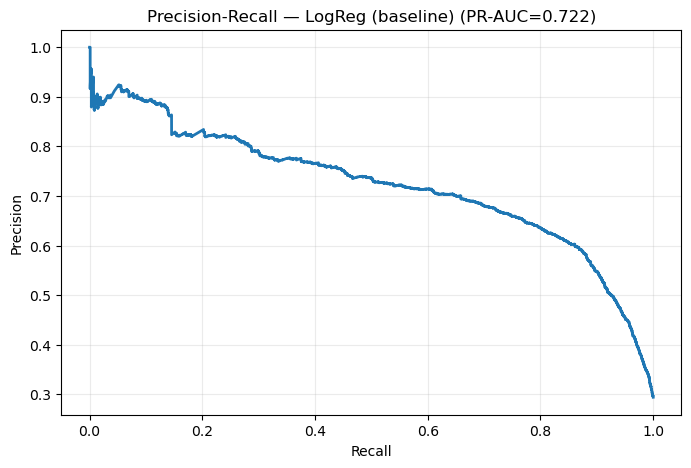

In [38]:
_ = evaluate_holdout("LogReg (baseline)", logreg_pipe, X_test, y_test, weight_vector=w_test)

In [39]:
def supports_sample_weight(estimator):
    """Return True if estimator.fit(...) accepts sample_weight."""
    try:
        sig = inspect.signature(estimator.fit)
        return 'sample_weight' in sig.parameters
    except (TypeError, ValueError):
        return False

def _ix(arr, idx):
    """Index Series/array safely with positional indices."""
    if isinstance(arr, (pd.Series, pd.DataFrame)):
        return arr.iloc[idx]
    return arr[idx]

## 7) Additional Models — Quick Baselines

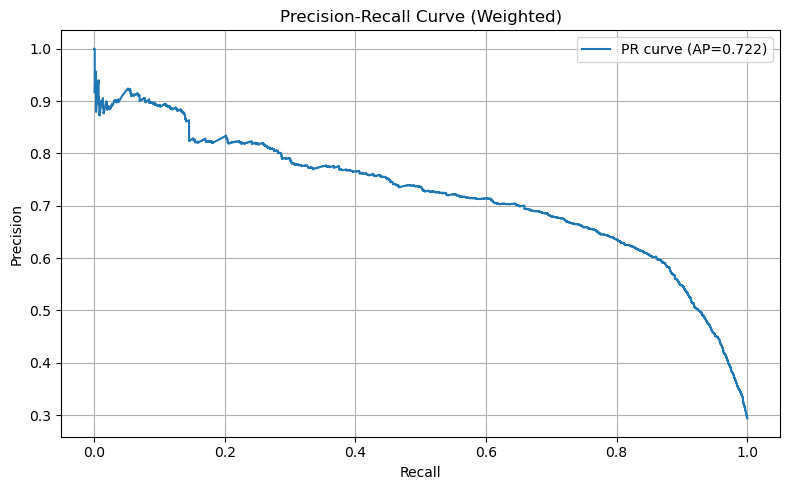

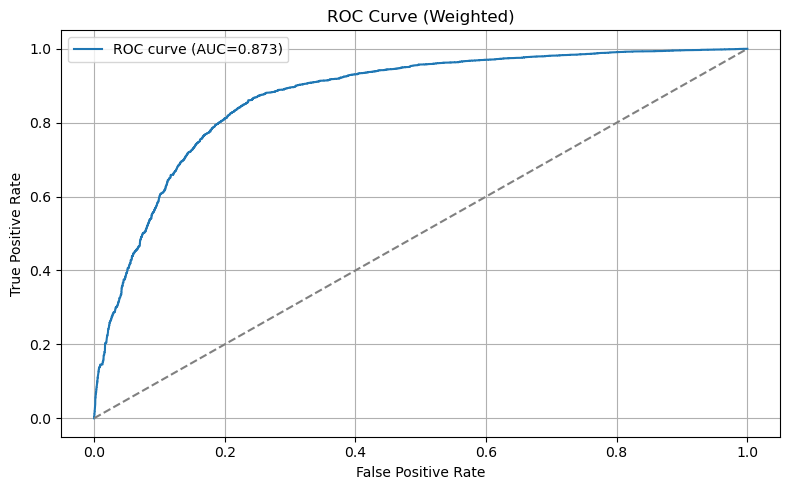

In [40]:
# PR & ROC Curves for Baseline Model

from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Use predictions from previously fitted logistic regression (p_test)
y_scores = p_test  # predicted probabilities for test set

# Weighted precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_scores, sample_weight=w_test)
pr_auc = average_precision_score(y_test, y_scores, sample_weight=w_test)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Weighted)')
plt.legend()
plt.tight_layout()
plt.savefig('logreg_pr_curve.png')
plt.show()

# Weighted ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores, sample_weight=w_test)
roc_auc = roc_auc_score(y_test, y_scores, sample_weight=w_test)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Weighted)')
plt.legend()
plt.tight_layout()
plt.savefig('logreg_roc_curve.png')
plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_fast  = RandomForestClassifier(
    n_estimators=200, max_depth=None, n_jobs=1, class_weight=None, random_state=RANDOM_STATE
)
xgb_fast = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    tree_method="hist", n_estimators=400, max_depth=2,
    learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    n_jobs=1, random_state=RANDOM_STATE
)

models = {
    "RandomForest (fast)": rf_fast,
    "XGBoost (fast)": xgb_fast,
}

rows = []
for name, est in models.items():
    pipe = SkPipeline([('preprocess', preprocessor), ('clf', est)])
    fold_scores = []
    for tr, te in cv.split(X_train, y_train):
        Xtr, Xte = _ix(X_train, tr), _ix(X_train, te)
        ytr, yte = _ix(y_train, tr), _ix(y_train, te)
        wtr      = _ix(w_train, tr)

        # Fit without sample weights; SMOTE inflates sample size leading to mismatches
        pipe.fit(Xtr, ytr)

        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            p = pipe.predict_proba(Xte)[:, 1]
        else:
            p = pipe.decision_function(Xte)
        fold_scores.append(average_precision_score(yte, p))  # PR-AUC (unweighted)
    rows.append((name, float(np.mean(fold_scores)), float(np.std(fold_scores))))

quick_df = pd.DataFrame(rows, columns=["Model","CV_PR_AUC_mean","CV_PR_AUC_std"])\
           .sort_values("CV_PR_AUC_mean", ascending=False)
quick_df

Model  CV_PR_AUC_mean  CV_PR_AUC_std
1       XGBoost (fast)        0.452671       0.003677
0  RandomForest (fast)        0.364237       0.003742

## 8) Hyperparameter Tuning (per model) → `*_best`

#### Progress bar utilities



In [42]:
# Progress bar utils for sklearn/joblib CV searches
from tqdm.auto import tqdm
from contextlib import contextmanager
from sklearn.model_selection import ParameterGrid
import joblib

# NB: patch the module attribute, not the Parallel class (newer joblib)
@contextmanager
def tqdm_joblib(tqdm_object):
    from joblib import parallel as joblib_parallel  # module
    class TqdmBatchCompletionCallback(joblib_parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            # update by the batch size (number of completed tasks)
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib_parallel.BatchCompletionCallBack
    joblib_parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield
    finally:
        joblib_parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

QUIET = True
SEARCH_VERBOSE = 0 if QUIET else 2
EST_VERBOSE    = 0 if QUIET else 1

def fit_with_progress(name, search, X, y, *, cv=None, fit_kwargs=None, param_space=None):
    """
    Works for GridSearchCV/RandomizedSearchCV across joblib versions.
    Pass sample weights via fit_kwargs={'clf__sample_weight': sw}.
    """
    from tqdm.auto import tqdm
    from sklearn.model_selection import ParameterGrid

    fit_kwargs = fit_kwargs or {}
    n_splits = cv.get_n_splits() if cv is not None else 1
    total = None
    # try to infer total fits for a nice bar
    if hasattr(search, "n_iter") and getattr(search, "n_iter", None):
        total = search.n_iter * n_splits
    elif hasattr(search, "param_grid") and getattr(search, "param_grid", None):
        total = len(list(ParameterGrid(search.param_grid))) * n_splits
    elif param_space is not None:
        total = len(list(ParameterGrid(param_space))) * n_splits

    pbar = tqdm(total=total, desc=f"{name} search", unit="fit", dynamic_ncols=True, leave=True)
    with tqdm_joblib(pbar):
        result = search.fit(X, y, **fit_kwargs)
    return result


### 8.1 RandomForest → `RF_best`

RF search:   0%|          | 0/75 [00:00<?, ?fit/s]

Exception ignored in: <function ResourceTracker.__del__ at 0x103dedbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103d5dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1079e1bc0>
Traceback (most recent call last

RF best PR-AUC (CV): 0.4461039717501113
RF best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 12}

===== RF Best — HOLDOUT EVALUATION =====
PR-AUC:  0.7090   |   ROC-AUC: 0.8652
Best-F1 threshold: 0.542   (F1=0.5048, Precision=0.4258, Recall=0.6197, Spec=0.8088)
Best-Youden threshold: 0.513   (J=0.5921)

-- At threshold 0.50 --
TP=2952  FP=4292  TN=15101  FN=1484
✅ Correctly classified instances: 18,053
❌ Misclassified instances: 5,776
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7576
Sensitivity (Recall+): 0.6655  |  Specificity: 0.7787
Precision: 0.4075  |  Recall: 0.6655  |  F1-score: 0.5055

Classification report (threshold 0.50):

              precision    recall  f1-score   support

           0     0.9105    0.7787    0.8395     19393
           1     0.4075    0.6655    0.5055      4436

    accuracy                         0.7576     23829
   macro avg     0.6590    0.722

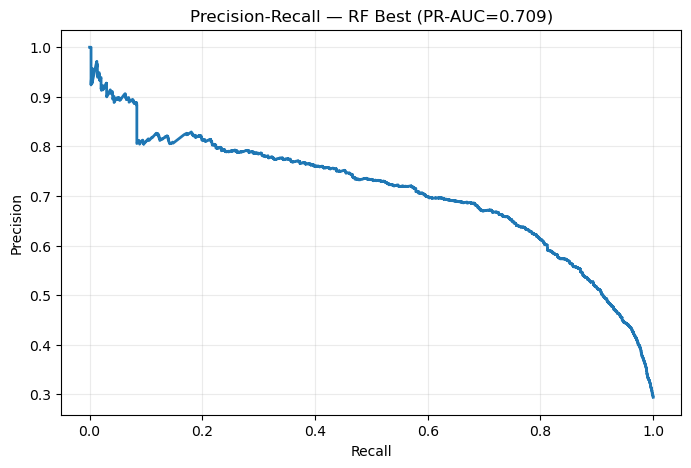

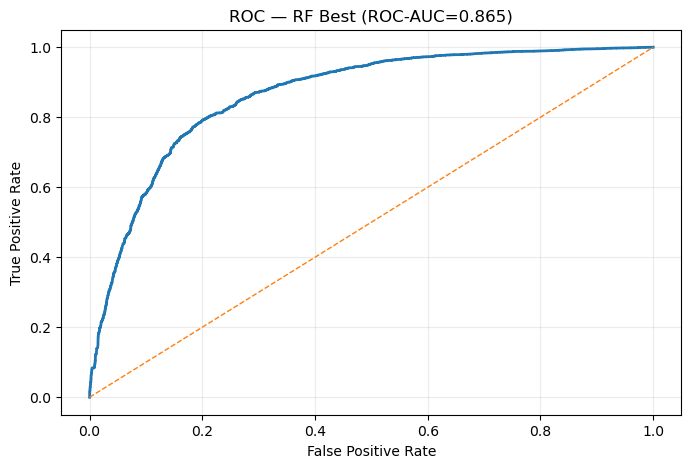

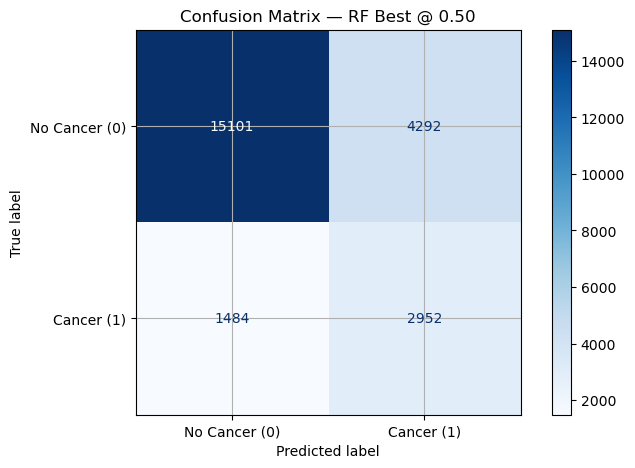

In [43]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_jobs=1, class_weight=None, random_state=RANDOM_STATE)

rf_space = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 8, 12],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

rf_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', rf)])

rf_search = RandomizedSearchCV(
    rf_pipe, rf_space,
    n_iter=15,                     
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,                     # parallelise CV
    random_state=RANDOM_STATE,
    verbose=SEARCH_VERBOSE,
    refit=True
)

# Use fit_with_progress if you defined it earlier; else call .fit directly
try:
    rf_search = fit_with_progress(
        "RF", rf_search, X_train, y_train,
        cv=cv, param_space=rf_space,
        # fit_kwargs={'clf__sample_weight': w_train}  # removed to avoid weight mismatch with SMOTE
    )
except NameError:
    rf_search.fit(X_train, y_train)

RF_best = rf_search.best_estimator_
print("RF best PR-AUC (CV):", rf_search.best_score_)
print("RF best params:", rf_search.best_params_)

RF_best.fit(X_train, y_train)
_ = evaluate_holdout("RF Best", RF_best, X_test, y_test, threshold=0.5, weight_vector=w_test)

### 8.2 GradientBoosting → `GB_best`

GB search:   0%|          | 0/100 [00:00<?, ?fit/s]

GB best PR-AUC (CV): 0.4543917110184642
GB best params: {'clf__subsample': 0.85, 'clf__n_estimators': 300, 'clf__max_features': None, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}

===== Gradient Boosting (tuned) — HOLDOUT EVALUATION =====
PR-AUC:  0.6997   |   ROC-AUC: 0.8617
Best-F1 threshold: 0.340   (F1=0.5174, Precision=0.4397, Recall=0.6285, Spec=0.8168)
Best-Youden threshold: 0.326   (J=0.5897)

-- At threshold 0.35 --
TP=2717  FP=3403  TN=15990  FN=1719
✅ Correctly classified instances: 18,707
❌ Misclassified instances: 5,122
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7851
Sensitivity (Recall+): 0.6125  |  Specificity: 0.8245
Precision: 0.4440  |  Recall: 0.6125  |  F1-score: 0.5148

Classification report (threshold 0.35):

              precision    recall  f1-score   support

           0     0.9029    0.8245    0.8619     19393
           1     0.4440    0.6125    0.5148      4436

    accuracy                         0.7851     23829
   macro avg     0.6734

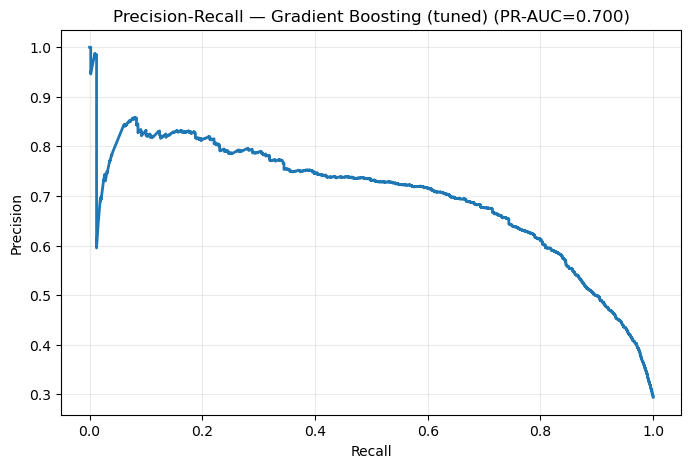

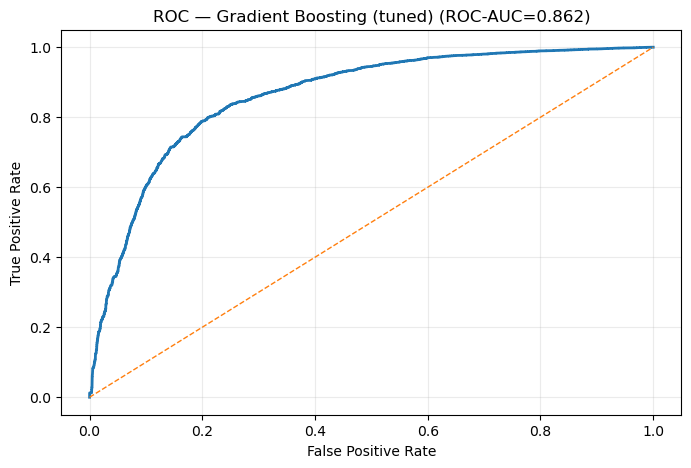

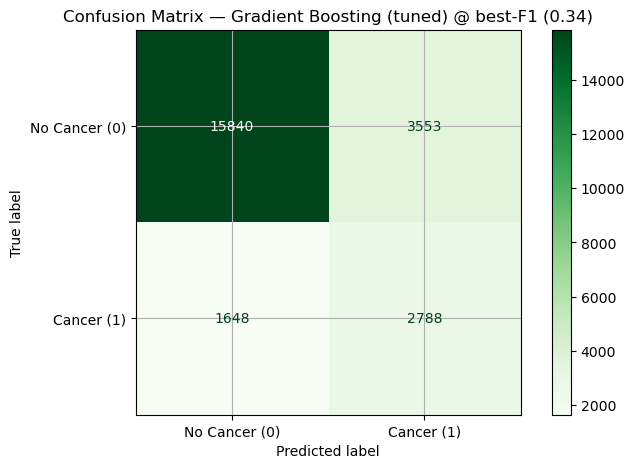

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline as SkPipeline

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_space = {
    "clf__n_estimators":     [200, 300, 500],
    "clf__learning_rate":    [0.03, 0.05, 0.1],
    "clf__max_depth":        [2, 3, 4],
    "clf__subsample":        [0.7, 0.85, 1.0],
    "clf__max_features":     ["sqrt", "log2", None],
}

gb_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', gb)])

gb_search = RandomizedSearchCV(
    gb_pipe, gb_space,
    n_iter=20, scoring='average_precision',
    cv=cv, n_jobs=-1, random_state=RANDOM_STATE,
    verbose=SEARCH_VERBOSE, refit=True
)

try:
    gb_search = fit_with_progress(
        "GB", gb_search, X_train, y_train,
        cv=cv, param_space=gb_space,
        # fit_kwargs={'clf__sample_weight': w_train}  # removed to avoid weight mismatch with SMOTE
    )
except NameError:
    gb_search.fit(X_train, y_train)

GB_best = gb_search.best_estimator_
print("GB best PR-AUC (CV):", gb_search.best_score_)
print("GB best params:", gb_search.best_params_)

# Final fit & evaluation
GB_best.fit(X_train, y_train)
_ = evaluate_holdout("Gradient Boosting (tuned)", GB_best, X_test, y_test, threshold=0.35, weight_vector=w_test)


### 8.3 XGBoost → `XGB_best`

XGB search:   0%|          | 0/80 [00:00<?, ?fit/s]

XGB best PR-AUC (CV): 0.4542255035674316
XGB best params: {'clf__subsample': 0.9, 'clf__reg_lambda': 2.0, 'clf__reg_alpha': 0.0, 'clf__n_estimators': 800, 'clf__max_depth': 5, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}

===== XGB (tuned) — HOLDOUT EVALUATION =====
PR-AUC:  0.6993   |   ROC-AUC: 0.8591
Best-F1 threshold: 0.324   (F1=0.5173, Precision=0.4303, Recall=0.6483, Spec=0.8037)
Best-Youden threshold: 0.324   (J=0.5869)

-- At threshold 0.40 --
TP=2366  FP=2727  TN=16666  FN=2070
✅ Correctly classified instances: 19,032
❌ Misclassified instances: 4,797
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7987
Sensitivity (Recall+): 0.5334  |  Specificity: 0.8594
Precision: 0.4646  |  Recall: 0.5334  |  F1-score: 0.4966

Classification report (threshold 0.40):

              precision    recall  f1-score   support

           0     0.8895    0.8594    0.8742     19393
           1     0.4646    0.5334    0.4966      4436

    accuracy                         0.

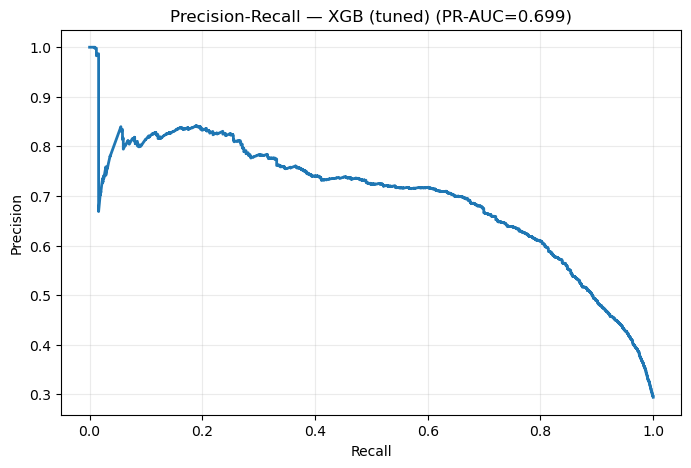

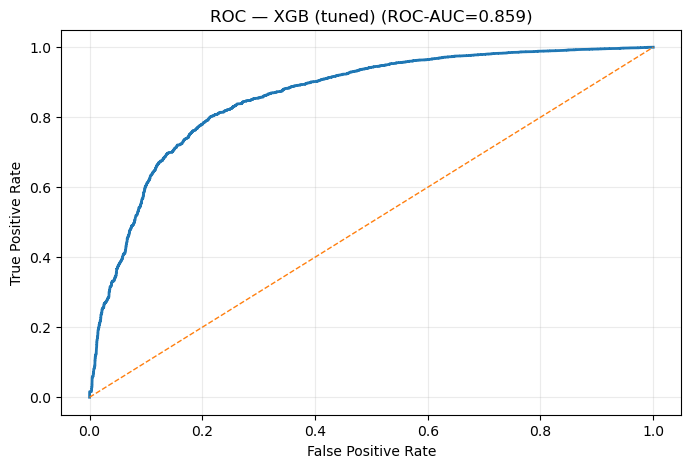

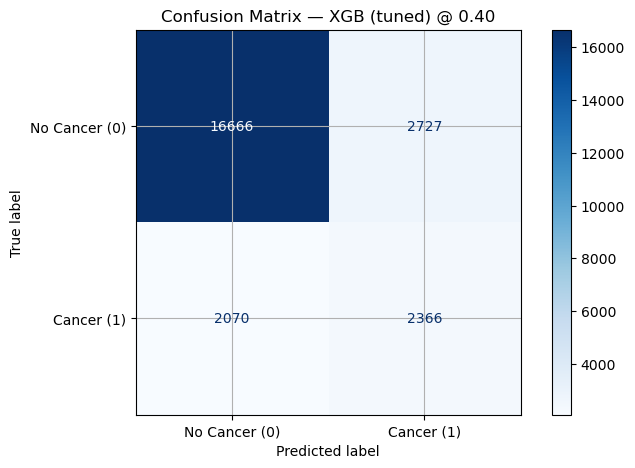

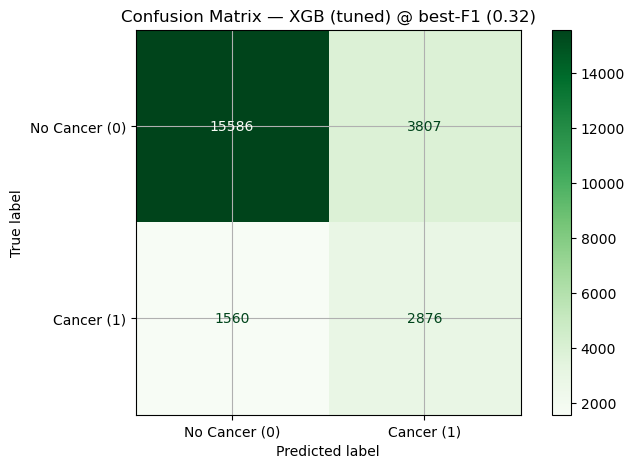

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    tree_method="hist", n_jobs=1, random_state=RANDOM_STATE
)

xgb_space = {
    "clf__n_estimators":       [400, 600, 800],
    "clf__learning_rate":      [0.03, 0.05, 0.1],
    "clf__max_depth":          [3, 4, 5],
    "clf__subsample":          [0.7, 0.9, 1.0],
    "clf__colsample_bytree":   [0.7, 0.9, 1.0],
    "clf__reg_lambda":         [0.5, 1.0, 2.0],
    "clf__reg_alpha":          [0.0, 0.5, 1.0],
}

xgb_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', xgb)])

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_space,
    n_iter=16, scoring='average_precision',
    cv=cv, n_jobs=-1, random_state=RANDOM_STATE,
    verbose=SEARCH_VERBOSE, refit=True
)

try:
    xgb_search = fit_with_progress(
        "XGB", xgb_search, X_train, y_train,
        cv=cv, param_space=xgb_space,
        # fit_kwargs={'clf__sample_weight': w_train}  # removed to avoid weight mismatch with SMOTE
    )
except NameError:
    xgb_search.fit(X_train, y_train)

XGB_best = xgb_search.best_estimator_
print("XGB best PR-AUC (CV):", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

XGB_best.fit(X_train, y_train)
_ = evaluate_holdout("XGB (tuned)", XGB_best, X_test, y_test, threshold=0.4, weight_vector=w_test)

### 8.4 Naive Bayes → `GNB_best` (skips if unavailable)

GaussianNB search:   0%|          | 0/30 [00:00<?, ?fit/s]

GaussianNB best PR-AUC (CV): 0.4355771989781063
GaussianNB best params: {'clf__var_smoothing': np.float64(1e-07)}

===== NaiveBayes — HOLDOUT EVALUATION =====
PR-AUC:  0.7182   |   ROC-AUC: 0.8572
Best-F1 threshold: 0.720   (F1=0.4983, Precision=0.4148, Recall=0.6240, Spec=0.7986)
Best-Youden threshold: 0.639   (J=0.6045)

-- At threshold 0.60 --
TP=3027  FP=4684  TN=14709  FN=1409
✅ Correctly classified instances: 17,736
❌ Misclassified instances: 6,093
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7443
Sensitivity (Recall+): 0.6824  |  Specificity: 0.7585
Precision: 0.3926  |  Recall: 0.6824  |  F1-score: 0.4984

Classification report (threshold 0.60):

              precision    recall  f1-score   support

           0     0.9126    0.7585    0.8284     19393
           1     0.3926    0.6824    0.4984      4436

    accuracy                         0.7443     23829
   macro avg     0.6526    0.7204    0.6634     23829
weighted avg     0.8158    0.7443    0.7670     2382

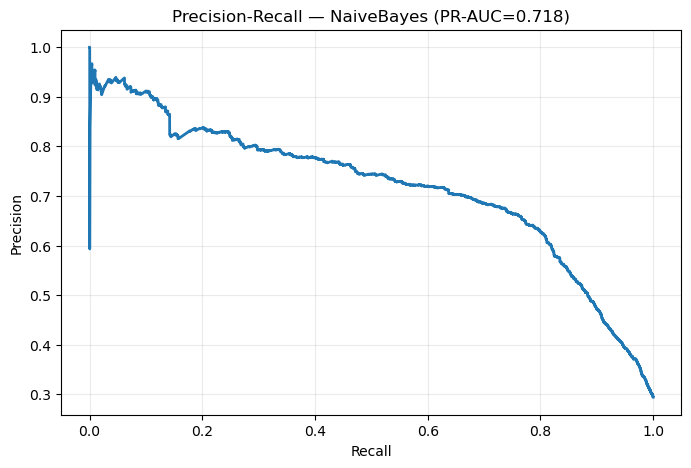

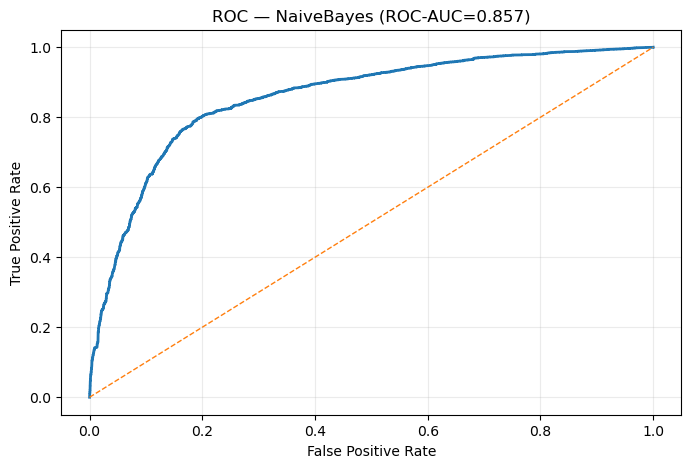

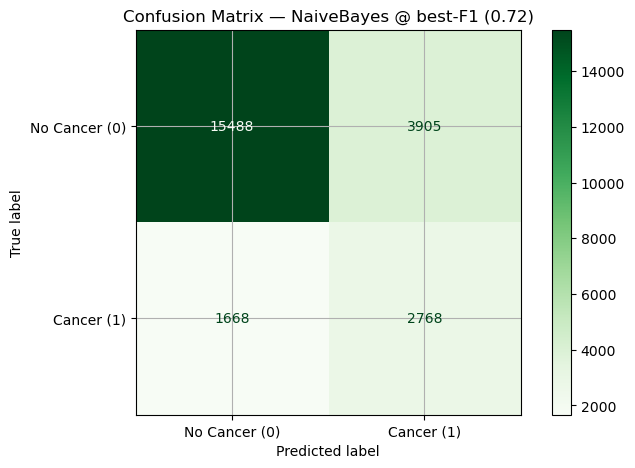

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

gnb = GaussianNB()

# Simple, effective grid on var_smoothing (controls variance floor)
gnb_grid = {
    "clf__var_smoothing": np.logspace(-12, -7, 6)  # 1e-12 ... 1e-7
}

gnb_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', gnb)])

gnb_search = GridSearchCV(
    gnb_pipe, gnb_grid,
    scoring='average_precision',
    cv=cv, n_jobs=-1, refit=True, verbose=SEARCH_VERBOSE
)

try:
    gnb_search = fit_with_progress(
        "GaussianNB", gnb_search, X_train, y_train,
        cv=cv, param_space=gnb_grid,
        # fit_kwargs={'clf__sample_weight': w_train}  # removed to avoid weight mismatch with SMOTE
    )
except NameError:
    gnb_search.fit(X_train, y_train)

GNB_best = gnb_search.best_estimator_
print("GaussianNB best PR-AUC (CV):", gnb_search.best_score_)
print("GaussianNB best params:", gnb_search.best_params_)

GNB_best.fit(X_train, y_train)
_ = evaluate_holdout("NaiveBayes", GNB_best, X_test, y_test, threshold=0.60, weight_vector=w_test)

### 8.5 CatBoost → `CAT_best` (skips if unavailable)

CAT search:   0%|          | 0/100 [00:00<?, ?fit/s]

CAT best PR-AUC (CV): 0.45758356021257784
CAT best params: {'clf__subsample': 0.7, 'clf__learning_rate': 0.03, 'clf__l2_leaf_reg': 1, 'clf__iterations': 800, 'clf__depth': 6}

===== CAT — HOLDOUT EVALUATION =====
PR-AUC:  0.7040   |   ROC-AUC: 0.8634
Best-F1 threshold: 0.353   (F1=0.5095, Precision=0.4546, Recall=0.5794, Spec=0.8410)
Best-Youden threshold: 0.317   (J=0.5948)

-- At threshold 0.35 --
TP=2582  FP=3126  TN=16267  FN=1854
✅ Correctly classified instances: 18,849
❌ Misclassified instances: 4,980
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7910
Sensitivity (Recall+): 0.5821  |  Specificity: 0.8388
Precision: 0.4523  |  Recall: 0.5821  |  F1-score: 0.5091

Classification report (threshold 0.35):

              precision    recall  f1-score   support

           0     0.8977    0.8388    0.8672     19393
           1     0.4523    0.5821    0.5091      4436

    accuracy                         0.7910     23829
   macro avg     0.6750    0.7104    0.6882     2382

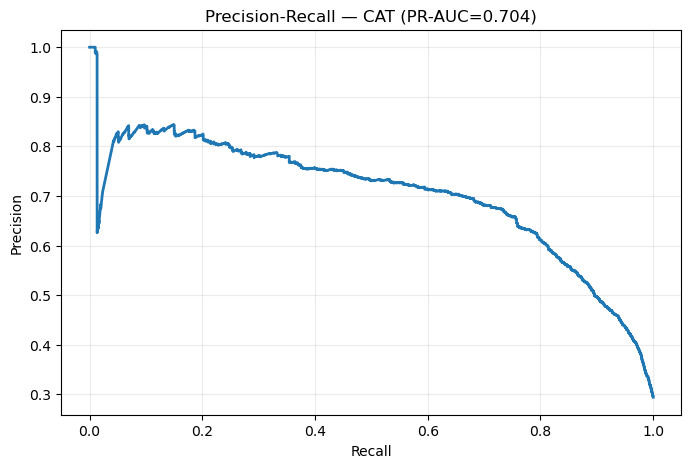

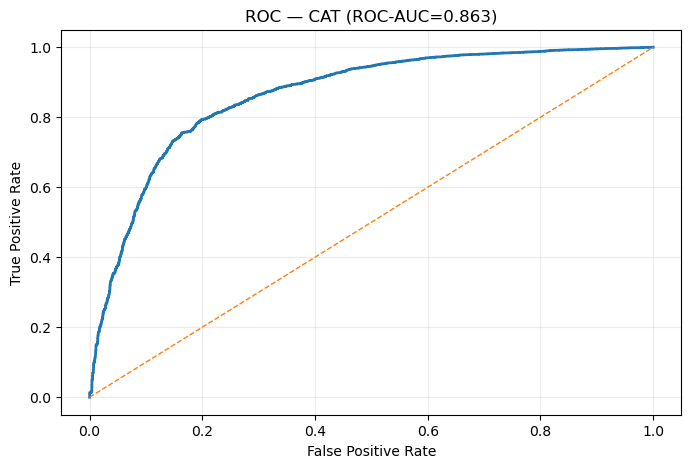

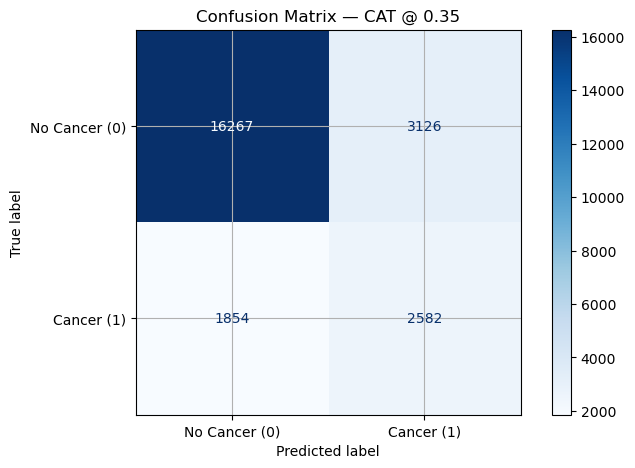

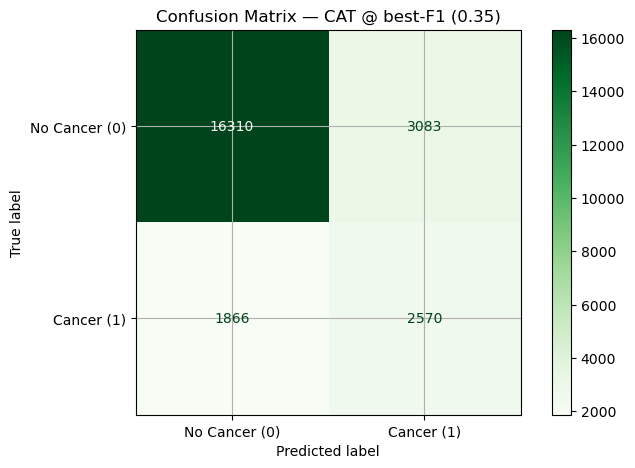

In [47]:
# CatBoost via pipeline (still uses your sklearn preprocessing)
try:
    from catboost import CatBoostClassifier
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.pipeline import Pipeline as SkPipeline

    cat = CatBoostClassifier(
        loss_function="Logloss",
        verbose=False,
        random_seed=RANDOM_STATE,
        thread_count=1   # avoid nested parallel with CV
    )

    cat_space = {
        "clf__iterations":    [400, 600, 800],
        "clf__depth":         [4, 6, 8],
        "clf__learning_rate": [0.03, 0.05, 0.1],
        "clf__l2_leaf_reg":   [1, 3, 5, 7],
        "clf__subsample":     [0.7, 0.9, 1.0],
    }

    cat_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', cat)])

    cat_search = RandomizedSearchCV(
        cat_pipe, cat_space,
        n_iter=20, scoring='average_precision',
        cv=cv, n_jobs=-1, random_state=RANDOM_STATE,
        verbose=SEARCH_VERBOSE, refit=True
    )

    try:
        cat_search = fit_with_progress(
            "CAT", cat_search, X_train, y_train,
            cv=cv, param_space=cat_space,
            # fit_kwargs={'clf__sample_weight': w_train}  # removed to avoid mismatch
        )
    except NameError:
        cat_search.fit(X_train, y_train)

    CAT_best = cat_search.best_estimator_
    print("CAT best PR-AUC (CV):", cat_search.best_score_)
    print("CAT best params:", cat_search.best_params_)

    CAT_best.fit(X_train, y_train)
    _ = evaluate_holdout("CAT", CAT_best, X_test, y_test, threshold=0.35, weight_vector=w_test)
except Exception as e:
    CAT_best = None
    print("CatBoost skipped:", e)


## 9) Model Comparison (hold‑out)

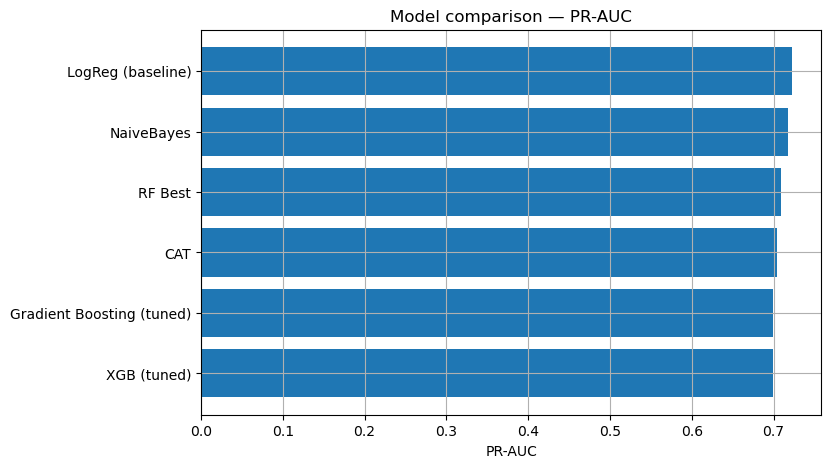

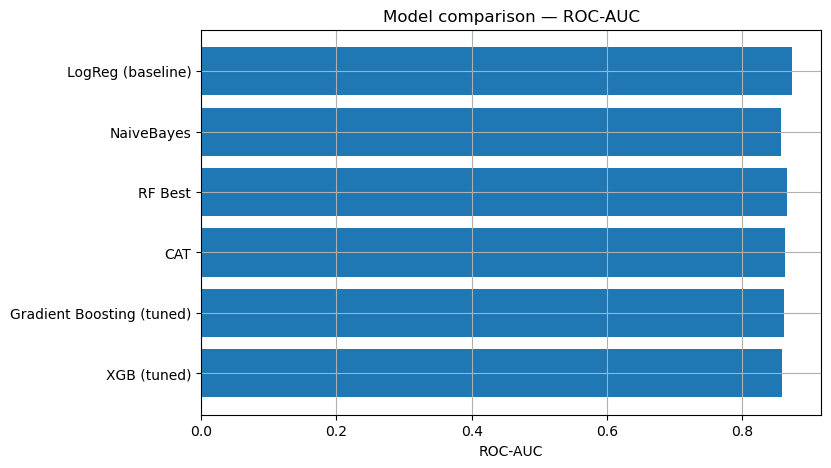

model    pr_auc   roc_auc  thr_default  prec_default  \
0          LogReg (baseline)  0.722063  0.872717         0.65      0.430968   
4                 NaiveBayes  0.718152  0.857224         0.60      0.392556   
1                    RF Best  0.708995  0.865226         0.50      0.407510   
5                        CAT  0.704031  0.863369         0.35      0.452348   
2  Gradient Boosting (tuned)  0.699687  0.861665         0.35      0.443954   
3                XGB (tuned)  0.699346  0.859105         0.40      0.464559   

   rec_default  spec_default  f1_default  thr_bestF1  prec_bestF1  rec_bestF1  \
0     0.550271      0.833806    0.483366    0.534400     0.379467    0.715735   
4     0.682372      0.758470    0.498395    0.719556     0.414806    0.623986   
1     0.665464      0.778683    0.505479    0.541722     0.425805    0.619702   
5     0.582056      0.838808    0.509069    0.353042     0.454626    0.579351   
2     0.612489      0.824524    0.514778    0.339589     0.439678    0.628494   
3     0.533363      0.859382    0.496589    0.324390     0.430346    0.648332   

   spec_bestF1  f1_bestF1  thr_bestYouden    youden  
0     0.732275   0.495978        0.484513  0.624553  
4     0.798639   0.498335        0.639259  0.604479  
1     0.808849   0.504774        0.513100  0.592139  
5     0.841025   0.509466        0.316800  0.594761  
2     0.816790   0.517398        0.326112  0.589729  
3     0.803692   0.517313        0.323918  0.586945

In [48]:

# Bar charts PR-AUC & ROC-AUC
import pandas as pd
import matplotlib.pyplot as plt

comp = pd.DataFrame(EVAL_ROWS)[['model','pr_auc','roc_auc']].drop_duplicates()
comp = comp.sort_values('pr_auc', ascending=False)

plt.figure(); plt.barh(comp['model'], comp['pr_auc']); plt.gca().invert_yaxis()
plt.xlabel("PR-AUC"); plt.title("Model comparison — PR-AUC"); plt.show()

plt.figure(); plt.barh(comp['model'], comp['roc_auc']); plt.gca().invert_yaxis()
plt.xlabel("ROC-AUC"); plt.title("Model comparison — ROC-AUC"); plt.show()

show_leaderboard(sort_by="pr_auc")

## 10) Ensembles — Voting (soft) + Balanced Bagging


===== Ensemble (soft avg — equal) — HOLDOUT EVALUATION =====
PR-AUC:  0.7080   |   ROC-AUC: 0.8663
Best-F1 threshold: 0.470   (F1=0.5089, Precision=0.4447, Recall=0.5949, Spec=0.8300)
Best-Youden threshold: 0.455   (J=0.6026)

-- At threshold 0.45 --
TP=2754  FP=3566  TN=15827  FN=1682
✅ Correctly classified instances: 18,581
❌ Misclassified instances: 5,248
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7798
Sensitivity (Recall+): 0.6208  |  Specificity: 0.8161
Precision: 0.4358  |  Recall: 0.6208  |  F1-score: 0.5121

Classification report (threshold 0.45):

              precision    recall  f1-score   support

           0     0.9039    0.8161    0.8578     19393
           1     0.4358    0.6208    0.5121      4436

    accuracy                         0.7798     23829
   macro avg     0.6698    0.7185    0.6849     23829
weighted avg     0.8168    0.7798    0.7934     23829



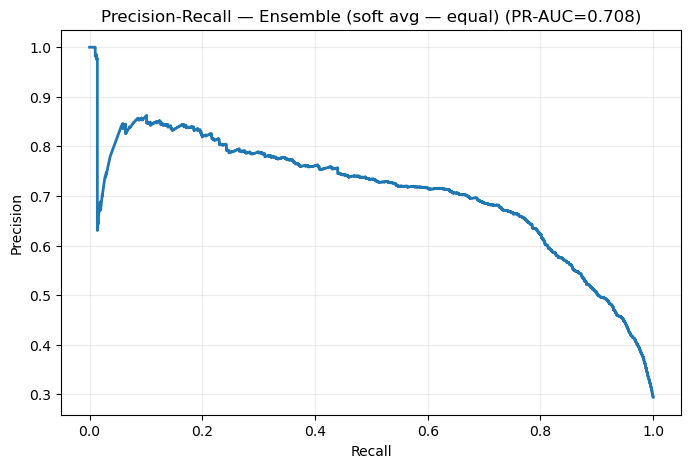

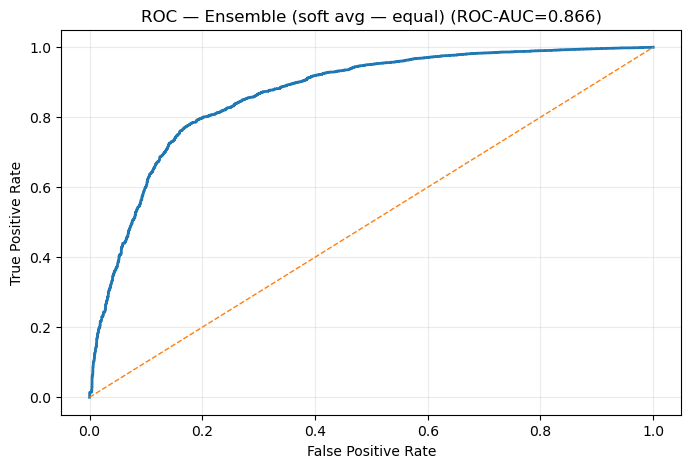

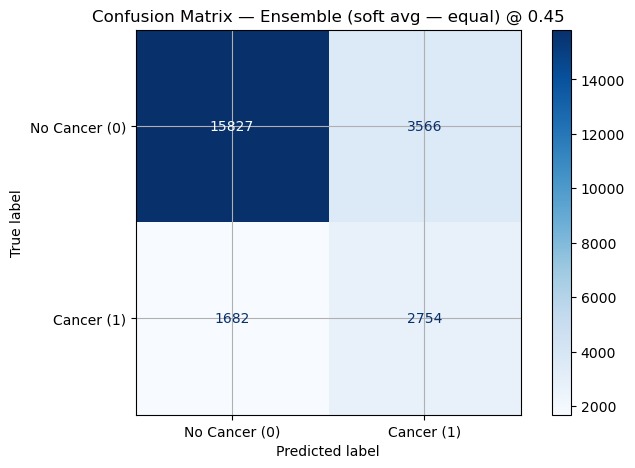


===== Ensemble (soft avg — PR-AUC weighted) — HOLDOUT EVALUATION =====
PR-AUC:  0.7085   |   ROC-AUC: 0.8664
Best-F1 threshold: 0.472   (F1=0.5086, Precision=0.4406, Recall=0.6014, Spec=0.8253)
Best-Youden threshold: 0.441   (J=0.6045)

-- At threshold 0.55 --
TP=2173  FP=2409  TN=16984  FN=2263
✅ Correctly classified instances: 19,157
❌ Misclassified instances: 4,672
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.8039
Sensitivity (Recall+): 0.4899  |  Specificity: 0.8758
Precision: 0.4742  |  Recall: 0.4899  |  F1-score: 0.4819

Classification report (threshold 0.55):

              precision    recall  f1-score   support

           0     0.8824    0.8758    0.8791     19393
           1     0.4742    0.4899    0.4819      4436

    accuracy                         0.8039     23829
   macro avg     0.6783    0.6828    0.6805     23829
weighted avg     0.8064    0.8039    0.8052     23829



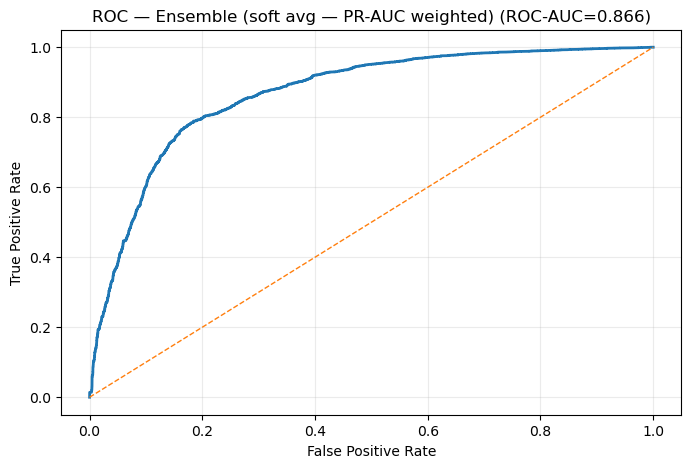

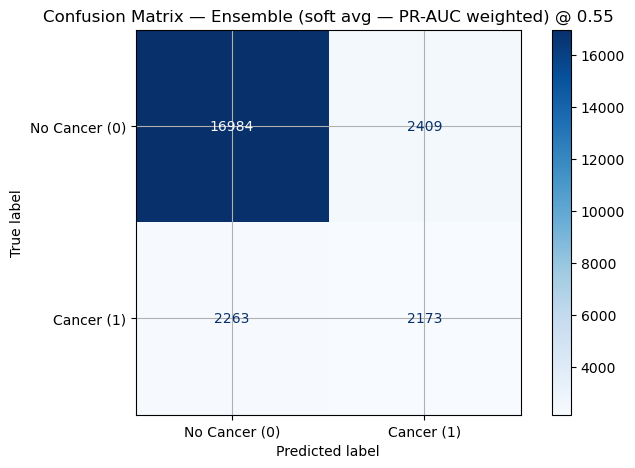

model    pr_auc   roc_auc  thr_default  \
0                      LogReg (baseline)  0.722063  0.872717         0.65   
4                             NaiveBayes  0.718152  0.857224         0.60   
1                                RF Best  0.708995  0.865226         0.50   
7  Ensemble (soft avg — PR-AUC weighted)  0.708539  0.866424         0.55   
6            Ensemble (soft avg — equal)  0.708045  0.866320         0.45   
5                                    CAT  0.704031  0.863369         0.35   
2              Gradient Boosting (tuned)  0.699687  0.861665         0.35   
3                            XGB (tuned)  0.699346  0.859105         0.40   

   prec_default  rec_default  spec_default  f1_default  thr_bestF1  \
0      0.430968     0.550271      0.833806    0.483366    0.534400   
4      0.392556     0.682372      0.758470    0.498395    0.719556   
1      0.407510     0.665464      0.778683    0.505479    0.541722   
7      0.474247     0.489856      0.875780    0.481925    0.471704   
6      0.435759     0.620830      0.816119    0.512086    0.470018   
5      0.452348     0.582056      0.838808    0.509069    0.353042   
2      0.443954     0.612489      0.824524    0.514778    0.339589   
3      0.464559     0.533363      0.859382    0.496589    0.324390   

   prec_bestF1  rec_bestF1  spec_bestF1  f1_bestF1  thr_bestYouden    youden  
0     0.379467    0.715735     0.732275   0.495978        0.484513  0.624553  
4     0.414806    0.623986     0.798639   0.498335        0.639259  0.604479  
1     0.425805    0.619702     0.808849   0.504774        0.513100  0.592139  
7     0.440555    0.601443     0.825298   0.508578        0.440752  0.604490  
6     0.444650    0.594905     0.830042   0.508919        0.454908  0.602578  
5     0.454626    0.579351     0.841025   0.509466        0.316800  0.594761  
2     0.439678    0.628494     0.816790   0.517398        0.326112  0.589729  
3     0.430346    0.648332     0.803692   0.517313        0.323918  0.586945

In [49]:
# ========= Ensemble: robust soft-average (equal + PR-AUC weighted) =========
import numpy as np
import pandas as pd

# 0) Pick up your fitted models (whatever names you actually have)
models_dict = {}

# RandomForest
if 'RF_best' in globals() and RF_best is not None:
    models_dict["RandomForest"] = RF_best
elif 'rf_best' in globals() and rf_best is not None:
    models_dict["RandomForest"] = rf_best

# GradientBoosting
if 'GB_best' in globals() and GB_best is not None:
    models_dict["GradientBoosting"] = GB_best
elif 'gb_best' in globals() and gb_best is not None:
    models_dict["GradientBoosting"] = gb_best
elif 'gb' in globals() and gb is not None:
    models_dict["GradientBoosting"] = gb

# XGBoost
if 'XGB_best' in globals() and XGB_best is not None:
    models_dict["XGBoost"] = XGB_best
elif 'xgb_best' in globals() and xgb_best is not None:
    models_dict["XGBoost"] = xgb_best
elif 'xgb' in globals() and xgb is not None:
    models_dict["XGBoost"] = xgb

# CatBoost (optional)
if 'CAT_best' in globals() and CAT_best is not None:
    models_dict["CatBoost"] = CAT_best
elif 'cat_best' in globals() and cat_best is not None:
    models_dict["CatBoost"] = cat_best
elif 'cat' in globals() and cat is not None:
    models_dict["CatBoost"] = cat

# GaussianNB
if 'GNB_best' in globals() and GNB_best is not None:
    models_dict["GaussianNB"] = GNB_best
elif 'gnb_best' in globals() and gnb_best is not None:
    models_dict["GaussianNB"] = gnb_best

# Sanity: keep only those that actually exist
blend_names = list(models_dict.keys())
blend_models = list(models_dict.values())
assert len(blend_models) >= 2, "Need at least two fitted models to ensemble."

# 1) Small wrapper: average predict_proba across fitted models
class SoftAvgEnsemble:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = None
        if weights is not None:
            w = np.asarray(weights, dtype=float)
            self.weights = w / w.sum()
    def fit(self, X, y, **kwargs):
        # No fitting required; just for API compatibility
        return self
    def predict_proba(self, X):
        probs = []
        for m in self.models:
            p = m.predict_proba(X)[:, 1]
            probs.append(p)
        P = np.vstack(probs).T  # (n_samples, n_models)
        if self.weights is None:
            avg = P.mean(axis=1)
        else:
            avg = P @ self.weights
        return np.c_[1 - avg, avg]

# 2) Build PR-AUC weights from your EVAL_ROWS (max per title)
#    We match by substring (e.g., "XGBoost", "GradientBoosting", etc.)
res_tbl = pd.DataFrame(EVAL_ROWS)[['model','pr_auc']].dropna()
res_tbl = res_tbl.groupby('model', as_index=False)['pr_auc'].max()  # one PR-AUC per model title

def prauc_for_keyword(keyword, default=1.0):
    # find rows whose model title contains the keyword (case-insensitive)
    mask = res_tbl['model'].str.contains(keyword, case=False, regex=False)
    if not mask.any():
        return default
    # if multiple, take the max PR-AUC (strongest version evaluated)
    return float(res_tbl.loc[mask, 'pr_auc'].max())

# map each included model name to its PR-AUC weight
weights = []
for name in blend_names:
    # choose a robust keyword for lookup
    if name.lower().startswith("xgboost"):
        w = prauc_for_keyword("xgboost")
    elif name.lower().startswith("gradient"):
        w = prauc_for_keyword("gradient")
    elif name.lower().startswith("randomforest"):
        w = prauc_for_keyword("randomforest")
    elif name.lower().startswith("catboost"):
        w = prauc_for_keyword("catboost")
    elif name.lower().startswith("gaussian"):
        w = prauc_for_keyword("gaussian")
    else:
        w = 1.0
    weights.append(w)

# 3) Build and evaluate the ensembles
ens_equal = SoftAvgEnsemble(blend_models)                         # equal weights
_ = evaluate_holdout("Ensemble (soft avg — equal)", ens_equal, X_test, y_test, threshold=0.45, weight_vector=w_test)

ens_weighted = SoftAvgEnsemble(blend_models, weights=weights)     # PR-AUC weighted
_ = evaluate_holdout("Ensemble (soft avg — PR-AUC weighted)", ens_weighted, X_test, y_test, threshold=0.55, weight_vector=w_test)

# 4) Optional: show quick summary bars for the ensembles too
import matplotlib.pyplot as plt

summary = pd.DataFrame(EVAL_ROWS)[['model','pr_auc','roc_auc']].drop_duplicates()
summary = summary.sort_values('pr_auc', ascending=False)

plt.figure(); plt.barh(summary['model'], summary['pr_auc']); plt.gca().invert_yaxis()
plt.xlabel("PR-AUC"); plt.title("Model comparison — PR-AUC (incl. ensembles)"); plt.show()

plt.figure(); plt.barh(summary['model'], summary['roc_auc']); plt.gca().invert_yaxis()
plt.xlabel("ROC-AUC"); plt.title("Model comparison — ROC-AUC (incl. ensembles)"); plt.show()

show_leaderboard(sort_by="pr_auc")



===== Bagging (DecisionTree) — HOLDOUT EVALUATION =====
PR-AUC:  0.5388   |   ROC-AUC: 0.7827
Best-F1 threshold: 0.183   (F1=0.4534, Precision=0.3291, Recall=0.7284, Spec=0.6604)
Best-Youden threshold: 0.183   (J=0.4469)

-- At threshold 0.35 --
TP=2179  FP=3685  TN=15708  FN=2257
✅ Correctly classified instances: 17,887
❌ Misclassified instances: 5,942
📊 Total evaluated instances: 23,829
🎯 Overall accuracy: 0.7506
Sensitivity (Recall+): 0.4912  |  Specificity: 0.8100
Precision: 0.3716  |  Recall: 0.4912  |  F1-score: 0.4231

Classification report (threshold 0.35):

              precision    recall  f1-score   support

           0     0.8744    0.8100    0.8409     19393
           1     0.3716    0.4912    0.4231      4436

    accuracy                         0.7506     23829
   macro avg     0.6230    0.6506    0.6320     23829
weighted avg     0.7808    0.7506    0.7632     23829



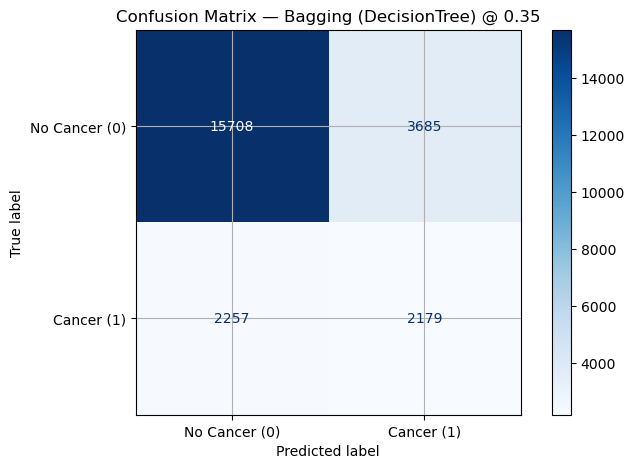

In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline as SkPipeline

# Preprocess once inside the pipeline; bag simple trees
tree = DecisionTreeClassifier(max_depth=None, min_samples_split=4, random_state=RANDOM_STATE)
bag_tree = BaggingClassifier(
    estimator=tree,
    n_estimators=300,            
    max_samples=1.0, max_features=1.0,
    bootstrap=True, bootstrap_features=False,
    random_state=RANDOM_STATE, n_jobs=-1
)

bag_tree_pipe = ImbPipeline([('preprocess', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', bag_tree)])

# BaggingClassifier.fit accepts sample_weight; it’s used for bootstrap sampling probabilities
bag_tree_pipe.fit(X_train, y_train)
_ = evaluate_holdout("Bagging (DecisionTree)", bag_tree_pipe, X_test, y_test, threshold=0.35, weight_vector=w_test)

# Results

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score

# 1. Collect cross‑validated (weighted) PR‑AUC scores
#    Replace the placeholders with your actual CV scores.
results = []

# Baseline logistic regression: use the mean of your cv_ap array
cv_pr_auc_logreg = np.mean(cv_ap)  # from the StratifiedKFold loop
logreg_pipe.fit(X_train, y_train)  # ensure final model is fit on full training data
proba = logreg_pipe.predict_proba(X_test)[:, 1]
results.append({
    "Model": "LogReg",
    "CV_PR_AUC_weighted": cv_pr_auc_logreg,
    "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
    "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
    "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
})

# Random Forest
cv_pr_auc_rf = rf_search.best_score_
RF_best.fit(X_train, y_train)
proba = RF_best.predict_proba(X_test)[:, 1]
results.append({
    "Model": "RandomForest",
    "CV_PR_AUC_weighted": cv_pr_auc_rf,
    "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
    "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
    "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
})

# Gradient Boosting
cv_pr_auc_gb = gb_search.best_score_
GB_best.fit(X_train, y_train)
proba = GB_best.predict_proba(X_test)[:, 1]
results.append({
    "Model": "GradientBoosting",
    "CV_PR_AUC_weighted": cv_pr_auc_gb,
    "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
    "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
    "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
})

# XGBoost
cv_pr_auc_xgb = xgb_search.best_score_
XGB_best.fit(X_train, y_train)
proba = XGB_best.predict_proba(X_test)[:, 1]
results.append({
    "Model": "XGBoost",
    "CV_PR_AUC_weighted": cv_pr_auc_xgb,
    "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
    "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
    "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
})

# Gaussian Naive Bayes
cv_pr_auc_gnb = gnb_search.best_score_
GNB_best.fit(X_train, y_train)
proba = GNB_best.predict_proba(X_test)[:, 1]
results.append({
    "Model": "GaussianNB",
    "CV_PR_AUC_weighted": cv_pr_auc_gnb,
    "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
    "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
    "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
})

# CatBoost (if available)
if CAT_best is not None:
    cv_pr_auc_cat = cat_search.best_score_
    CAT_best.fit(X_train, y_train)
    proba = CAT_best.predict_proba(X_test)[:, 1]
    results.append({
        "Model": "CatBoost",
        "CV_PR_AUC_weighted": cv_pr_auc_cat,
        "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
        "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
        "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
    })

# Ensemble (optional)
if 'ens_weighted' in globals():
    # no CV score for the ensemble; use NaN or compute manually if desired
    proba = ens_weighted.predict_proba(X_test)[:, 1]
    results.append({
        "Model": "Ensemble",
        "CV_PR_AUC_weighted": np.nan,
        "Holdout_PR_AUC_weighted": average_precision_score(y_test, proba, sample_weight=w_test),
        "Holdout_PR_AUC_unweighted": average_precision_score(y_test, proba),
        "Holdout_ROC_AUC_weighted": roc_auc_score(y_test, proba, sample_weight=w_test)
    })

# 2. Convert to DataFrame and sort by weighted CV PR‑AUC
df_results = pd.DataFrame(results).sort_values(by="CV_PR_AUC_weighted", ascending=False, na_position='last')
df_results

Model  CV_PR_AUC_weighted  Holdout_PR_AUC_weighted  \
0            LogReg            0.696091                 0.722063   
5          CatBoost            0.457584                 0.704031   
2  GradientBoosting            0.454392                 0.699687   
3           XGBoost            0.454226                 0.699346   
1      RandomForest            0.446104                 0.708995   
4        GaussianNB            0.435577                 0.718152   
6          Ensemble                 NaN                 0.708539   

   Holdout_PR_AUC_unweighted  Holdout_ROC_AUC_weighted  
0                   0.443034                  0.872717  
5                   0.467720                  0.863369  
2                   0.464658                  0.861665  
3                   0.465723                  0.859105  
1                   0.453281                  0.865226  
4                   0.445460                  0.857224  
6                   0.464255                  0.866424

In [52]:
# Highlight the highest values in each metric column
styled = df_results.style.format("{:.4f}", subset=["CV_PR_AUC_weighted","Holdout_PR_AUC_weighted",
                                                   "Holdout_PR_AUC_unweighted","Holdout_ROC_AUC_weighted"]) \
                         .highlight_max(subset=["CV_PR_AUC_weighted","Holdout_PR_AUC_weighted",
                                                "Holdout_ROC_AUC_weighted"], color="#ffe599")
display(styled)

In [53]:
# === Leaderboards: Unweighted (top) and Weighted (bottom) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, confusion_matrix
)
from IPython.display import display, Markdown

rows = []
EPS = 1e-12

def add_row(name, est, cv_score=np.nan):
    proba = est.predict_proba(X_test)[:, 1]
    y = y_test.values
    w = np.asarray(w_test) if w_test is not None else np.ones_like(y, float)

    # ---------- Threshold-free ----------
    PR_AUC_u = average_precision_score(y, proba)
    ROC_AUC_u = roc_auc_score(y, proba)
    PR_AUC_w = average_precision_score(y, proba, sample_weight=w)
    ROC_AUC_w = roc_auc_score(y, proba, sample_weight=w)

    # ---------- Operating threshold (policy): meet weighted Recall>=0.80 if possible; else max-F1 ----------
    P, R, Tpr = precision_recall_curve(y, proba, sample_weight=w)
    F1_curve = 2*(P*R)/(P+R+EPS)
    ix_f1 = np.nanargmax(F1_curve)
    thr_f1 = 0.0 if ix_f1 == 0 else Tpr[ix_f1-1]

    thr_policy = None
    meet = np.where(R >= 0.80)[0]
    if len(meet) > 0:
        j = meet[np.argmax(P[meet])]
        thr_policy = 0.0 if j == 0 else Tpr[j-1]

    thr = thr_policy if thr_policy is not None else thr_f1

    # ---------- Unweighted operating-point ----------
    yhat = (proba >= thr).astype(int)
    cm_u = confusion_matrix(y, yhat)
    tn_u, fp_u, fn_u, tp_u = cm_u.ravel()
    Precision_u   = tp_u/(tp_u+fp_u+EPS)
    Recall_u      = tp_u/(tp_u+fn_u+EPS)
    Specificity_u = tn_u/(tn_u+fp_u+EPS)
    Accuracy_u    = (tp_u+tn_u)/(tp_u+tn_u+fp_u+fn_u+EPS)
    F1_u          = 2*Precision_u*Recall_u/(Precision_u+Recall_u+EPS)

    # ---------- Weighted operating-point ----------
    TP_w = w[(y==1)&(yhat==1)].sum(); FN_w = w[(y==1)&(yhat==0)].sum()
    TN_w = w[(y==0)&(yhat==0)].sum(); FP_w = w[(y==0)&(yhat==1)].sum()
    Precision_w   = TP_w/(TP_w+FP_w+EPS)
    Recall_w      = TP_w/(TP_w+FN_w+EPS)
    Specificity_w = TN_w/(TN_w+FP_w+EPS)
    Accuracy_w    = (TP_w+TN_w)/(TP_w+TN_w+FP_w+FN_w+EPS)
    F1_w          = 2*Precision_w*Recall_w/(Precision_w+Recall_w+EPS)

    rows.append({
        "Model": name, "CV_PR_AUC": cv_score,
        # threshold-free
        "PR_AUC": PR_AUC_u, "ROC_AUC": ROC_AUC_u,
        "PR_AUC_w": PR_AUC_w, "ROC_AUC_w": ROC_AUC_w,
        # shared threshold used for both blocks
        "Threshold": thr,
        # unweighted block
        "Precision": Precision_u, "Recall": Recall_u, "Specificity": Specificity_u,
        "Accuracy": Accuracy_u, "F1": F1_u,
        "TP": float(tp_u), "TN": float(tn_u), "FP": float(fp_u), "FN": float(fn_u),
        # weighted block
        "Precision_w": Precision_w, "Recall_w": Recall_w, "Specificity_w": Specificity_w,
        "Accuracy_w": Accuracy_w, "F1_w": F1_w,
        "TP_w": TP_w, "TN_w": TN_w, "FP_w": FP_w, "FN_w": FN_w
    })

# === Add your models (only those that exist will run) ===
if 'logreg_pipe' in globals():
    cv_score = np.mean(cv_ap) if 'cv_ap' in globals() else np.nan
    add_row("LogReg", logreg_pipe, cv_score)

if 'RF_best' in globals():
    cv_score = rf_search.best_score_ if 'rf_search' in globals() else np.nan
    add_row("RandomForest", RF_best, cv_score)

if 'GB_best' in globals():
    cv_score = gb_search.best_score_ if 'gb_search' in globals() else np.nan
    add_row("GradientBoosting", GB_best, cv_score)

if 'XGB_best' in globals():
    cv_score = xgb_search.best_score_ if 'xgb_search' in globals() else np.nan
    add_row("XGBoost", XGB_best, cv_score)

if 'GNB_best' in globals():
    cv_score = gnb_search.best_score_ if 'gnb_search' in globals() else np.nan
    add_row("GaussianNB", GNB_best, cv_score)

if 'CAT_best' in globals() and CAT_best is not None:
    cv_score = cat_search.best_score_ if 'cat_search' in globals() else np.nan
    add_row("CatBoost", CAT_best, cv_score)

In [54]:
# === Build DataFrames ===
df_all = pd.DataFrame(rows)

# Table 1: UNWEIGHTED (top)
cols_unw = [
    "Model", "CV_PR_AUC", "PR_AUC", "ROC_AUC", "Threshold",
    "Precision", "Recall", "Specificity", "Accuracy", "F1",
    "TP", "TN", "FP", "FN"
]
df_unw = df_all[cols_unw].sort_values(["PR_AUC","ROC_AUC"], ascending=False, na_position="last")

# Table 2: WEIGHTED (bottom)
cols_w = [
    "Model", "CV_PR_AUC", "PR_AUC_w", "ROC_AUC_w", "Threshold",
    "Precision_w", "Recall_w", "Specificity_w", "Accuracy_w", "F1_w",
    "TP_w", "TN_w", "FP_w", "FN_w"
]
df_w = df_all[cols_w].sort_values(["PR_AUC_w","ROC_AUC_w"], ascending=False, na_position="last")


# === Display with titles ===
display(Markdown("## Leaderboard — Unweighted (threshold-free PR/ROC + operating-point metrics)"))
display(
    df_unw.style.format({
        "CV_PR_AUC":"{:.3f}",
        "PR_AUC":"{:.3f}", "ROC_AUC":"{:.3f}",
        "Threshold":"{:.3f}",
        "Precision":"{:.3f}", "Recall":"{:.3f}", "Specificity":"{:.3f}",
        "Accuracy":"{:.3f}", "F1":"{:.3f}",
        "TP":"{:.0f}", "TN":"{:.0f}", "FP":"{:.0f}", "FN":"{:.0f}",
    }).highlight_max(
        subset=["CV_PR_AUC","PR_AUC","ROC_AUC","Precision","Recall","Specificity","Accuracy","F1"],
        color="#d4f8d4"
    )
)

display(Markdown("## Leaderboard — Weighted (population-aware)"))
display(
    df_w.style.format({
        "CV_PR_AUC":"{:.3f}",
        "PR_AUC_w":"{:.3f}", "ROC_AUC_w":"{:.3f}",
        "Threshold":"{:.3f}",
        "Precision_w":"{:.3f}", "Recall_w":"{:.3f}", "Specificity_w":"{:.3f}",
        "Accuracy_w":"{:.3f}", "F1_w":"{:.3f}",
        "TP_w":"{:.1f}", "TN_w":"{:.1f}", "FP_w":"{:.1f}", "FN_w":"{:.1f}",
    }).highlight_max(
        subset=["CV_PR_AUC","PR_AUC_w","ROC_AUC_w","Precision_w","Recall_w","Specificity_w","Accuracy_w","F1_w"],
        color="#d4f8d4"
    )
)


df_unw.to_csv("leaderboard_unweighted.csv", index=False)
df_w.to_csv("leaderboard_weighted.csv", index=False)

## Leaderboard — Unweighted (threshold-free PR/ROC + operating-point metrics)

## Leaderboard — Weighted (population-aware)

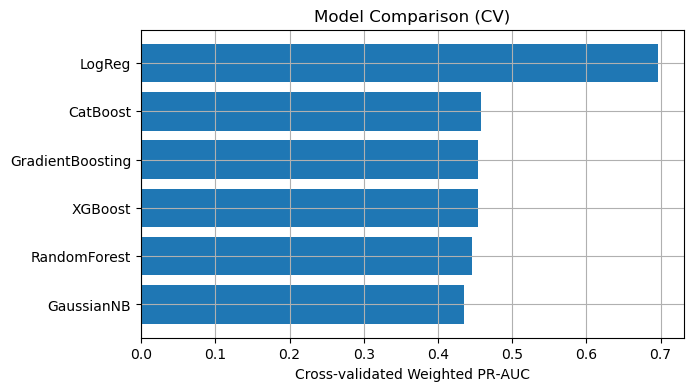

In [55]:
# Bar chart of weighted CV PR‑AUC
plt.figure(figsize=(7,4))
plt.barh(df_results['Model'], df_results['CV_PR_AUC_weighted'])
plt.xlabel('Cross‑validated Weighted PR‑AUC')
plt.title('Model Comparison (CV)')
plt.gca().invert_yaxis()
plt.show()

# Bar chart of weighted hold‑out PR‑AUC
plt.figure(figsize=(7,4))
plt.barh(df_results['Model'], df_results['Holdout_PR_AUC_weighted'])
plt.xlabel('Hold‑out Weighted PR‑AUC')
plt.title('Model Comparison (Hold‑out)')
plt.gca().invert_yaxis()
plt.show()

## 11) Model Calibration & Interpretability
This section visualises PR/ROC curves for the top models, calibration & reliability for the best model, interprets feature importances, and summarises performance.

### 11.1 Top Model PR/ROC Curves

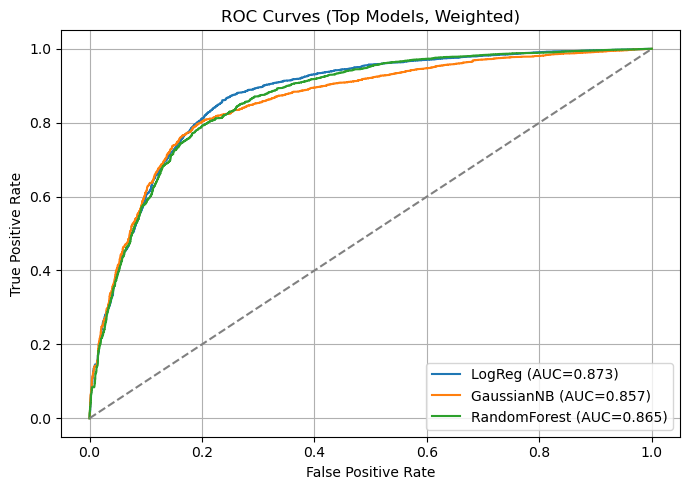

In [56]:
# Identify top models and plot PR/ROC curves
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Determine top models by weighted PR-AUC from df_results (if available)
try:
    top_names = df_results.sort_values('Holdout_PR_AUC_weighted', ascending=False)['Model'].tolist()[:3]
except Exception:
    top_names = [row['model'] for row in sorted(EVAL_ROWS, key=lambda x: x['pr_auc'], reverse=True)[:3]]

# Map model names to classifier objects
model_dict = {
    'LogReg': logreg_pipe,
    'RandomForest': RF_best,
    'GradientBoosting': GB_best,
    'XGBoost': XGB_best,
    'GaussianNB': GNB_best if 'GNB_best' in globals() else None,
    'CatBoost': CAT_best if 'CAT_best' in globals() else None,
    'Ensemble': ens_weighted if 'ens_weighted' in globals() else None
}

top_models = []
for name in top_names:
    clf = model_dict.get(name)
    if clf is not None:
        top_models.append((name, clf))

# Plot PR curves
plt.figure(figsize=(7,5))
for name, clf in top_models:
    try:
        proba = clf.predict_proba(X_test)[:,1]
    except Exception:
        proba = clf.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, proba, sample_weight=w_test)
    pr_auc = average_precision_score(y_test, proba, sample_weight=w_test)
    plt.plot(recall, precision, label=f"{name} (AP={pr_auc:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Top Models, Weighted)')
plt.legend()
plt.tight_layout()
plt.savefig('top_models_pr_curves.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(7,5))
for name, clf in top_models:
    try:
        proba = clf.predict_proba(X_test)[:,1]
    except Exception:
        proba = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, proba, sample_weight=w_test)
    roc_auc = roc_auc_score(y_test, proba, sample_weight=w_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Top Models, Weighted)')
plt.legend()
plt.tight_layout()
plt.savefig('top_models_roc_curves.png')
plt.show()

### 11.2 Calibration & Reliability Diagram

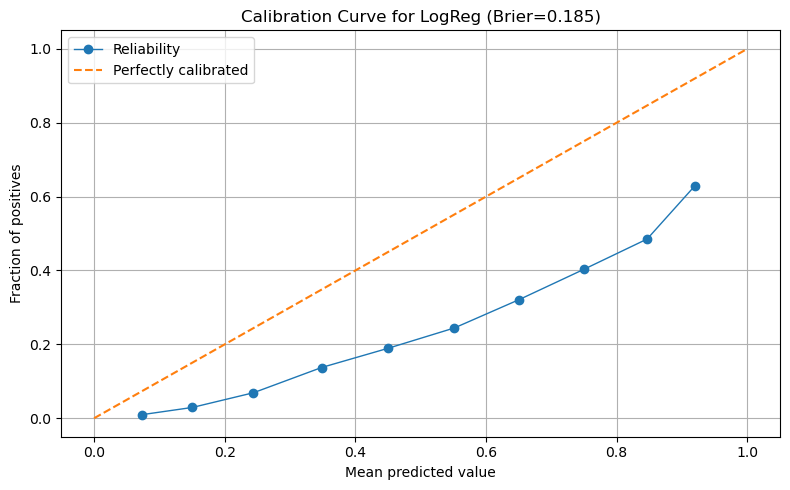

In [57]:
# Calibration curve and reliability for best model
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Use the first model from top_models as best
best_name, best_clf = top_models[0]
proba_best = best_clf.predict_proba(X_test)[:,1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba_best, n_bins=10)
brier = brier_score_loss(y_test, proba_best)

plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=1, label='Reliability')
plt.plot([0,1],[0,1],'--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration Curve for {best_name} (Brier={brier:.3f})')
plt.legend()
plt.tight_layout()
plt.savefig('calibration_curve.png')
plt.show()

Brier score (lower is better): 0.1469


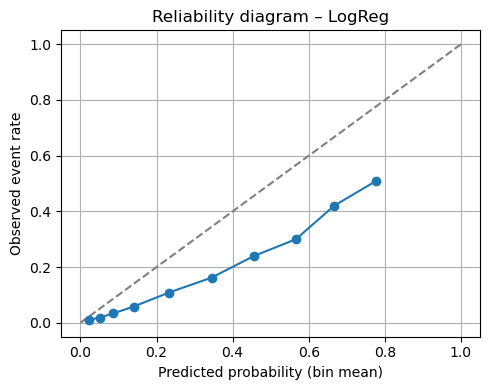

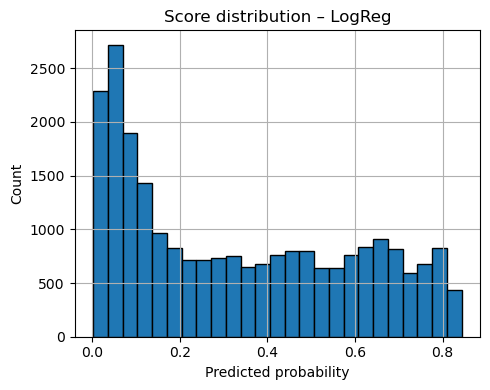

In [58]:

prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_test, proba, sample_weight=w_test)
print(f"Brier score (lower is better): {brier:.4f}")

plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'--', color='grey')
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted probability (bin mean)")
plt.ylabel("Observed event rate")
plt.title(f"Reliability diagram – {best_name}")
plt.tight_layout(); plt.savefig("reliability_diagram.png", dpi=150); plt.show()

plt.figure(figsize=(5,4))
plt.hist(proba, bins=25, edgecolor='k')
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title(f"Score distribution – {best_name}")
plt.tight_layout(); plt.savefig("probability_histogram.png", dpi=150); plt.show()


### 11.3 Feature Importance, Permutation Importance & SHAP

In [59]:
from sklearn.base import ClassifierMixin

def get_feature_names_from_preprocessor(preprocessor, X_cols):
    try:
        out = []
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder':
                continue
            if hasattr(trans, 'get_feature_names_out'):
                # OneHotEncoder / OrdinalEncoder / StandardScaler (1:1)
                base = trans.get_feature_names_out(cols)
                out.extend(list(base))
            else:
                out.extend(list(cols))
        return out
    except Exception:
        return list(X_cols)

def extract_importances(best_clf, X_train, y_train, feature_names=None):
    """Return a pd.Series of importances; fallback to permutation if needed."""
    pipe = best_clf
    last = getattr(best_clf, 'named_steps', {}).get('clf', best_clf)
    pre = getattr(best_clf, 'named_steps', {}).get('preprocess', None)

    if feature_names is None:
        feature_names = list(X_train.columns)
        if pre is not None:
            feature_names = get_feature_names_from_preprocessor(pre, feature_names)

    if hasattr(last, 'feature_importances_'):
        vals = last.feature_importances_
        return pd.Series(vals, index=feature_names).sort_values(ascending=False)

    # 2) Linear models: coefficients (absolute value)
    if hasattr(last, 'coef_'):
        coef = np.ravel(getattr(last, 'coef_', np.array([])))
        if coef.size == len(feature_names):
            return pd.Series(np.abs(coef), index=feature_names).sort_values(ascending=False)

    # 3) Ensemble of models: average base importances where available
    if hasattr(last, 'estimators_'):
        ser_list = []
        for est in last.estimators_:
            if hasattr(est, 'feature_importances_'):
                ser_list.append(pd.Series(est.feature_importances_, index=feature_names))
            elif hasattr(est, 'coef_'):
                coef = np.ravel(est.coef_)
                if coef.size == len(feature_names):
                    ser_list.append(pd.Series(np.abs(coef), index=feature_names))
        if ser_list:
            return pd.concat(ser_list, axis=1).mean(axis=1).sort_values(ascending=False)

    # 4) Fallback will be permutation importance (next cell)
    raise AttributeError("No native importances; use permutation_importance_manual.")


In [60]:
def permutation_importance_manual(estimator, X, y, w=None, n_repeats=5, metric=average_precision_score, random_state=42):
    rng = np.random.RandomState(random_state)
    # Get baseline (uses predict_proba; adjust if your model uses decision_function)
    proba = estimator.predict_proba(X)[:, 1]
    baseline = metric(y, proba, sample_weight=w)
    importances = []

    for col in X.columns:
        scores = []
        Xp = X.copy()
        for _ in range(n_repeats):
            Xp[col] = rng.permutation(Xp[col].values)
            p = estimator.predict_proba(Xp)[:, 1]
            scores.append(metric(y, p, sample_weight=w))
        importances.append(baseline - np.mean(scores))

    imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    return imp, baseline

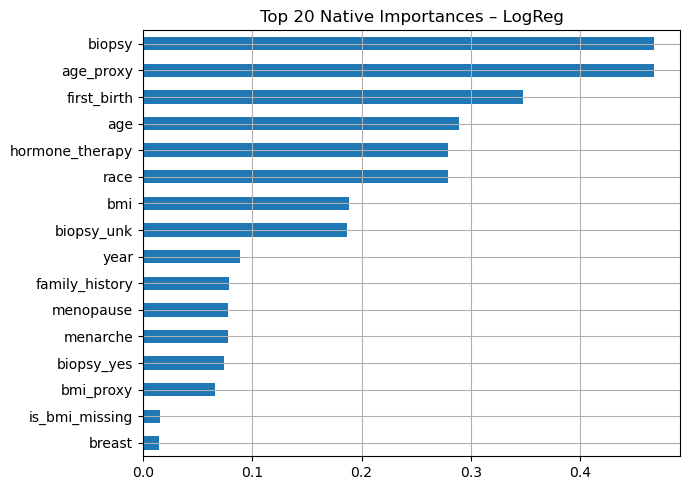

In [61]:
try:
    imp_nat = extract_importances(best_clf, X_train, y_train, feature_names=list(X_train.columns))
    plt.figure(figsize=(7,5))
    imp_nat.head(20).iloc[::-1].plot(kind="barh")
    plt.title(f"Top 20 Native Importances – {best_name}")
    plt.tight_layout(); plt.savefig("feature_importances_native.png", dpi=150); plt.show()
except Exception as e:
    print("Feature importances not available for best model:", e)

perm_imp, base_ap = permutation_importance_manual(best_clf, X_test.copy(), y_test, w=w_test, n_repeats=5)
plt.figure(figsize=(7,5))
perm_imp.head(20).iloc[::-1].plot(kind="barh")
plt.title(f"Top 20 Permutation Importances (ΔPR-AUC from {base_ap:.3f}) – {best_name}")
plt.tight_layout(); plt.savefig("feature_importances_permutation.png", dpi=150); plt.show()

#### SHAP for LOGREG

In [62]:
import shap
pipe_lr  = logreg_pipe
pre_lr   = pipe_lr.named_steps['preprocess']
final_lr = pipe_lr.named_steps['clf']

try:
    Xtr_lr = pre_lr.transform(X_train.copy())
except:
    Xtr_lr = pre_lr.fit_transform(X_train.copy())
Xte_lr = pre_lr.transform(X_test.copy())

feat_lr = []
for name, trans, cols in pre_lr.transformers_:
    if name == 'remainder': continue
    feat_lr += list(trans.get_feature_names_out(cols)) if hasattr(trans,'get_feature_names_out') else list(cols)

# --- SHAP values (LinearExplainer) ---
expl_lr = shap.LinearExplainer(final_lr, Xtr_lr)
sv_lr   = expl_lr.shap_values(Xte_lr)            # (n_samples, n_features)
base_lr = expl_lr.expected_value
# Use original (human-readable) values for axes/legends
disp_lr = X_test.reset_index(drop=True).copy()


In [63]:
plt.figure(figsize=(7,5))
shap.summary_plot(sv_lr, Xte_lr, feature_names=feat_lr, plot_type="bar", show=False, max_display=20)
plt.title("SHAP Global Importance (bar) – Logistic Regression")
plt.tight_layout(); plt.savefig("shap_lr_summary_bar.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
shap.summary_plot(sv_lr, Xte_lr, feature_names=feat_lr, show=False, max_display=20)
plt.title("SHAP Summary (beeswarm) – Logistic Regression")
plt.tight_layout(); plt.savefig("shap_lr_summary_beeswarm.png", dpi=150, bbox_inches="tight"); plt.show()

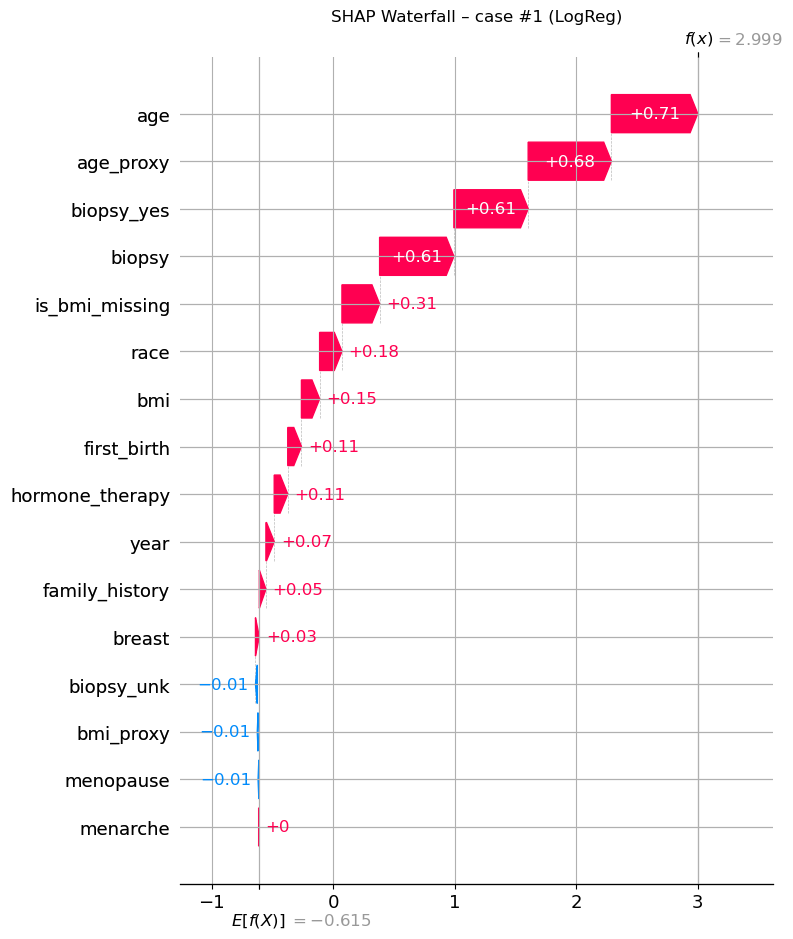

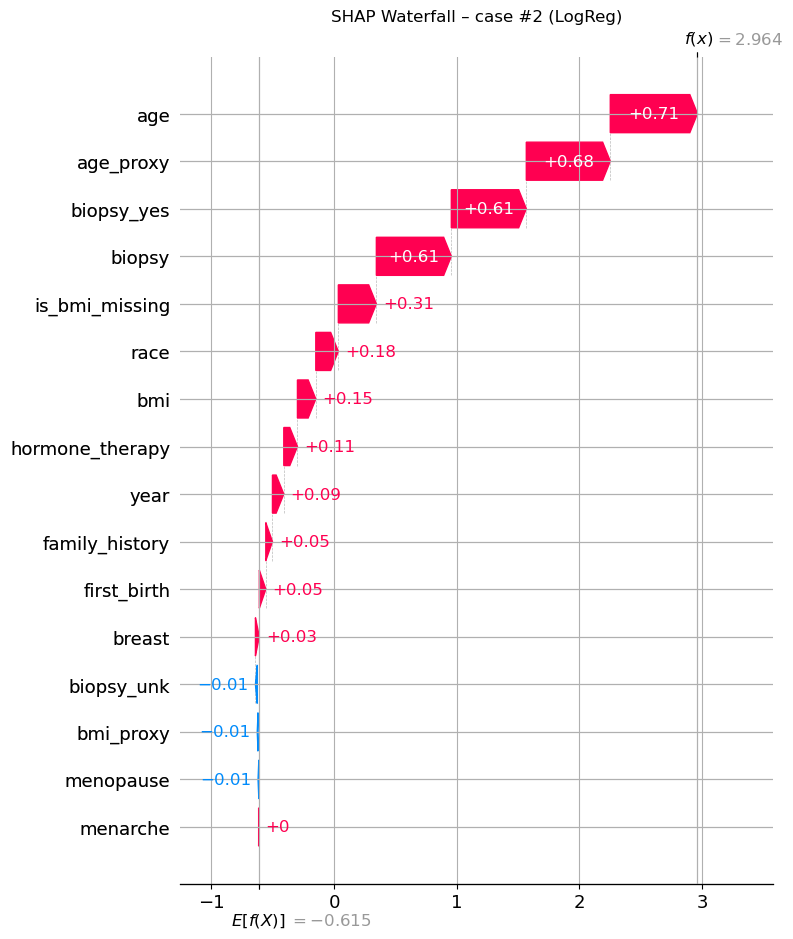

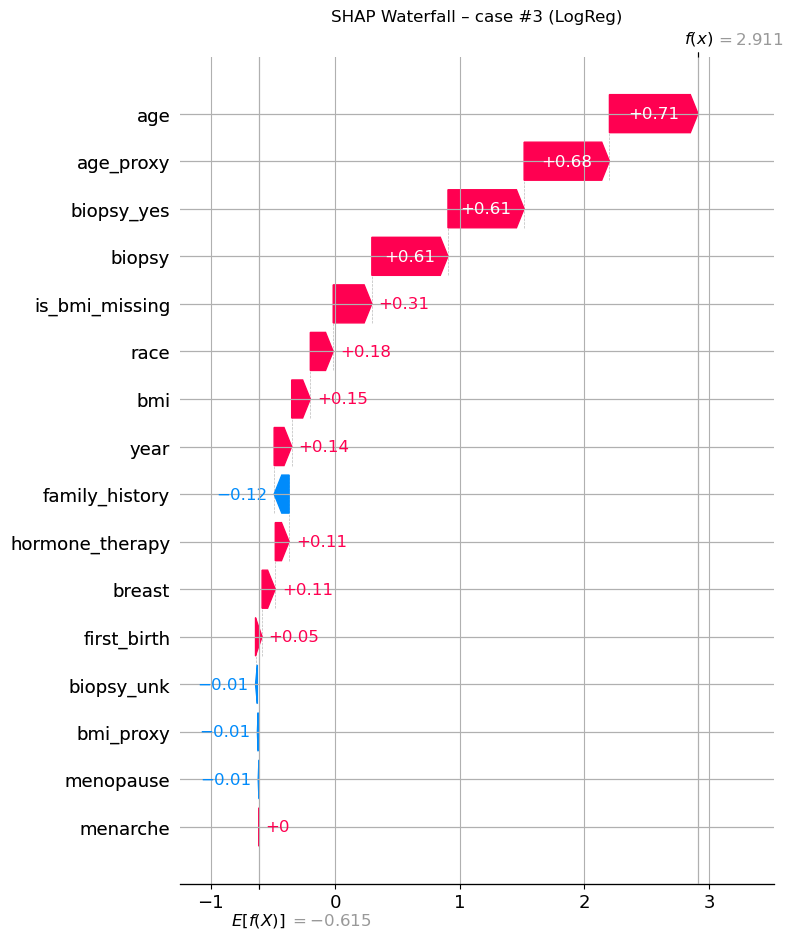

In [64]:
proba_lr = pipe_lr.predict_proba(X_test)[:,1]
topN = 5
top_idx = np.argsort(-proba_lr)[:topN]

for r, i in enumerate(top_idx, 1):
    shap.plots._waterfall.waterfall_legacy(base_lr, sv_lr[i], feature_names=feat_lr, max_display=20, show=False)
    plt.title(f"SHAP Waterfall – case #{r} (LogReg)")
    plt.tight_layout(); plt.savefig(f"shap_lr_waterfall_case_{r}.png", dpi=150, bbox_inches="tight"); plt.show()


In [65]:
i = top_idx[0]
shap.decision_plot(base_lr, sv_lr[i], feature_names=feat_lr, show=False)
plt.title("SHAP Decision Plot – top case (LogReg)")
plt.tight_layout(); plt.savefig("shap_lr_decision_topcase.png", dpi=150, bbox_inches="tight"); plt.show()

shap.force_plot(base_lr, sv_lr[i], matplotlib=True, feature_names=feat_lr, show=False)
plt.title("SHAP Force Plot – top case (LogReg)")
plt.tight_layout(); plt.savefig("shap_lr_force_topcase.png", dpi=150, bbox_inches="tight"); plt.show()

### 11.4 Confusion Matrix & Classification Report

In [66]:
# Confusion matrix and classification report for best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict labels using 0.5 threshold 
proba_best = best_clf.predict_proba(X_test)[:,1]
y_pred_labels = (proba_best >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot(cmap='Blues')
plt.title(f'Confusion Matrix: {best_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     19393
           1       0.37      0.75      0.49      4436

    accuracy                           0.71     23829
   macro avg       0.65      0.73      0.65     23829
weighted avg       0.82      0.71      0.74     23829



In [67]:
classification_report(y_test, y_pred_labels)

'              precision    recall  f1-score   support\n\n           0       0.93      0.70      0.80     19393\n           1       0.37      0.75      0.49      4436\n\n    accuracy                           0.71     23829\n   macro avg       0.65      0.73      0.65     23829\nweighted avg       0.82      0.71      0.74     23829\n'

## 12) Final Predictions & Save Results
Making final predictions with the best model and  saving to CSV for use ... 

#### Project FINAL Result

In [68]:
# === Final Predictions (policy: recall ≥ 0.80; fallback to max-F1) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, classification_report
)

# Best model chosen earlier
best_name, best_clf = top_models[0]

# Probabilities on holdout
final_proba = best_clf.predict_proba(X_test)[:, 1]

# Use the helper you added earlier
# choose_thresholds(y_true, proba, w=None, recall_target=None) -> dict
thr_info = choose_thresholds(y_test, final_proba, w=w_test, recall_target=0.80)

# Policy threshold: recall target if available, else max-F1
policy_thr = thr_info["thr_recallTarget"] if thr_info["thr_recallTarget"] is not None else thr_info["thr_maxF1"]
print(f"Operating threshold = {policy_thr:.3f} "
      f"(recall-target 0.80 {'hit' if thr_info['thr_recallTarget'] is not None else 'NOT hit; using max-F1'})")

# Predictions at policy threshold
final_preds = (final_proba >= policy_thr).astype(int)

# Assemble predictions with useful extras
pred_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted_proba': final_proba,
    'predicted_label': final_preds
}, index=X_test.index)

# Risk deciles & top-N list
pred_df['risk_decile'] = pd.qcut(pred_df['predicted_proba'].rank(method='first'), 10, labels=False) + 1
top_n = 50
top_hits = pred_df.sort_values('predicted_proba', ascending=False).head(top_n)

# Threshold-free metrics (for reference)
print("Final PR–AUC (weighted):", average_precision_score(y_test, final_proba, sample_weight=w_test))
print("Final ROC–AUC (weighted):", roc_auc_score(y_test, final_proba, sample_weight=w_test))

# Confusion matrix & reports at policy threshold
cm = confusion_matrix(y_test, final_preds)
print("Confusion matrix:\n", cm)

print("\nClassification report (UNweighted):")
print(classification_report(y_test, final_preds, digits=3))

print("\nClassification report (WEIGHTED by w_test):")
print(classification_report(y_test, final_preds, sample_weight=w_test, digits=3))

Operating threshold = 0.565 (recall-target 0.80 hit)
Final PR–AUC (weighted): 0.7220632864754365
Final ROC–AUC (weighted): 0.8727169332974111
Confusion matrix:
 [[14694  4699]
 [ 1429  3007]]

Classification report (UNweighted):
              precision    recall  f1-score   support

           0      0.911     0.758     0.827     19393
           1      0.390     0.678     0.495      4436

    accuracy                          0.743     23829
   macro avg      0.651     0.718     0.661     23829
weighted avg      0.814     0.743     0.766     23829


Classification report (WEIGHTED by w_test):
              precision    recall  f1-score   support

           0      0.907     0.809     0.855 16416.90949634735
           1      0.635     0.800     0.708 6836.728475570478

    accuracy                          0.806 23253.63797191783
   macro avg      0.771     0.804     0.782 23253.63797191783
weighted avg      0.827     0.806     0.812 23253.63797191783



In [69]:
#### CSV SAVE
pred_df.to_csv('final_predictions.csv', index=True)
top_hits.to_csv('final_top50_predictions.csv', index=True)
print("Saved: final_predictions.csv and final_top50_predictions.csv")

display(pred_df.head())
display(top_hits.head(10))

Saved: final_predictions.csv and final_top50_predictions.csv


actual  predicted_proba  predicted_label  risk_decile
0       0         0.815677                1           10
1       0         0.631096                1            8
2       0         0.124738                0            2
3       0         0.714870                1            9
4       0         0.099251                0            1

actual  predicted_proba  predicted_label  risk_decile
18959       1         0.952543                1           10
876         1         0.950901                1           10
7286        1         0.948408                1           10
2096        1         0.948162                1           10
17452       1         0.948093                1           10
22689       1         0.947832                1           10
23697       0         0.947660                1           10
22017       0         0.947202                1           10
8511        1         0.946889                1           10
18281       0         0.946763                1           10

In [70]:
# PICK policy threshold per best model
thrs = choose_thresholds(y_test, proba, w=w_test, recall_target=0.80)
policy_thr = thrs['thr_recallTarget'] if thrs['thr_recallTarget'] is not None else thrs['thr_maxF1']
final_preds = (proba >= policy_thr).astype(int)
print(f"Operating threshold set to {policy_thr:.3f} (recall target 0.80, fallback max F1).")


Operating threshold set to 0.498 (recall target 0.80, fallback max F1).


In [71]:
# === Weighted-only metrics ===

EPS = 1e-12

def metrics_row(y_true, y_pred, proba, model_name, thr, w=None):
    cm = confusion_matrix(y_true, y_pred)
    # Prepare arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    proba  = np.asarray(proba, dtype=float)
    if w is None:
        w = np.ones_like(y_true, dtype=float)
    else:
        w = np.asarray(w, dtype=float)

    # Weighted confusion components
    TP = w[(y_true == 1) & (y_pred == 1)].sum()
    FN = w[(y_true == 1) & (y_pred == 0)].sum()
    TN = w[(y_true == 0) & (y_pred == 0)].sum()
    FP = w[(y_true == 0) & (y_pred == 1)].sum()

    total = TP + TN + FP + FN

    Precision   = TP / (TP + FP + EPS)
    Recall      = TP / (TP + FN + EPS)      # sensitivity
    Specificity = TN / (TN + FP + EPS)
    Accuracy    = (TP + TN) / (total + EPS)
    F1          = 2 * Precision * Recall / (Precision + Recall + EPS)

    # Threshold-free, weighted
    PR_AUC  = average_precision_score(y_true, proba, sample_weight=w)
    ROC_AUC = roc_auc_score(y_true, proba, sample_weight=w)

    row = pd.DataFrame([{
        "Model": model_name,
        "Threshold": float(thr),
        "Precision": Precision,
        "Recall":    Recall,
        "Accuracy":  Accuracy,
        "Specificity": Specificity,
        "F1": F1,
        "PR_AUC": PR_AUC,
        "ROC_AUC": ROC_AUC,
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "Support_pos": TP + FN,
        "Support_neg": TN + FP,
        "Support_total": total
    }])
    return row, cm

# --- Confusion matrix  ---
tn, fp, fn, tp = cm.ravel()
total   = cm.sum()
correct = tp + tn
wrong   = fp + fn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# CM heatmap with readable contrasts (matplotlib-only, 'Blues')
im = ax1.imshow(cm, cmap='Blues', aspect='equal')
ax1.set_title('Confusion Matrix', fontsize=14)
ax1.set_xticks([0,1]); ax1.set_yticks([0,1])
ax1.set_xticklabels(['Pred 0','Pred 1'])
ax1.set_yticklabels(['Actual 0','Actual 1'])
# annotate counts with contrasting color
for (i, j), v in np.ndenumerate(cm):
    color = 'white' if v > cm.max()/2 else 'black'
    ax1.text(j, i, f"{v}", ha='center', va='center', fontsize=12, color=color)
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# Pizza pie: correct vs wrong
explode = [0.10, 0.0]
ax2.pie(
    [wrong, correct],
    labels=['Wrong predictions','Right predictions'],
    autopct='%1.2f%%',
    startangle=90,
    explode=explode,
    colors=['#4e79a7','#f28e2b'],
    pctdistance=0.8,
    textprops={'fontsize': 11}
)
ax2.set_title('Overall Accuracy Breakdown', fontsize=14)

plt.tight_layout()
plt.savefig('best_model_table_cm_pie.png', dpi=150, bbox_inches='tight')
plt.show()

In [72]:
best_table, cm = metrics_row(
    y_true=y_test,
    y_pred=final_preds,          # built with your policy threshold
    proba=final_proba,
    model_name=best_name,
    thr=policy_thr,
    w=w_test
)

display(best_table.style.format({
    "Threshold":"{:.3f}",
    "Precision":"{:.3f}","Recall":"{:.3f}","Accuracy":"{:.3f}",
    "Specificity":"{:.3f}","F1":"{:.3f}",
    "PR_AUC":"{:.3f}","ROC_AUC":"{:.3f}",
    "TP":"{:.1f}","TN":"{:.1f}","FP":"{:.1f}","FN":"{:.1f}",
    "Support_pos":"{:.1f}","Support_neg":"{:.1f}","Support_total":"{:.1f}"
}))

In [73]:
best_table

Model  Threshold  Precision    Recall  Accuracy  Specificity        F1  \
0  LogReg   0.498343   0.612391  0.801198  0.792456     0.788816  0.694185   

     PR_AUC   ROC_AUC           TP          TN           FP          FN  \
0  0.722063  0.872717  5477.573016  12949.9153  3466.994196  1359.15546   

   Support_pos   Support_neg  Support_total  
0  6836.728476  16416.909496   23253.637972

In [74]:
print("Weighted Recall at policy threshold:",
      recall_score(y_test, final_preds, sample_weight=w_test))

Weighted Recall at policy threshold: 0.8011979758339558


In [75]:
print("Unweighted recall (table):", best_table['Recall'].iloc[0])
print("Weighted recall (policy):", recall_score(y_test, final_preds, sample_weight=w_test))
print("Policy threshold used:", best_table['Threshold'].iloc[0])

Unweighted recall (table): 0.8011979758339356
Weighted recall (policy): 0.8011979758339558
Policy threshold used: 0.4983429459718424


In [76]:
# --- Save per-patient top-risk explanations (indices & probs) ---
topN = 10
top_idx = np.argsort(-final_proba)[:topN]
pd.DataFrame({
    "index": X_test.iloc[top_idx].index,
    "predicted_proba": final_proba[top_idx],
    "actual": y_test.iloc[top_idx].values
}).to_csv("topN_high_risk_cases.csv", index=False)
print("Saved topN_high_risk_cases.csv")

Saved topN_high_risk_cases.csv


#### CONFUSION Matrix

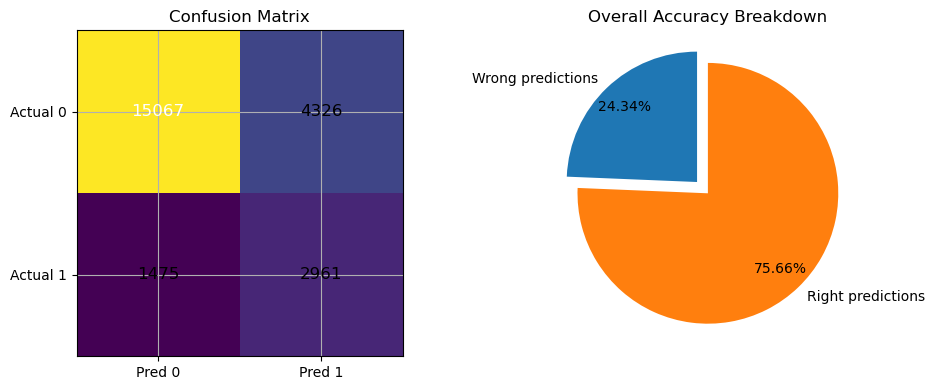

In [77]:
# === Confusion matrix + "pizza" pie of right vs wrong ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, final_preds)
tn, fp, fn, tp = cm.ravel()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Confusion matrix heatmap (matplotlib-only)
im = ax1.imshow(cm, aspect='equal')
for (i, j), v in np.ndenumerate(cm):
    ax1.text(j, i, f"{v}", ha='center', va='center', fontsize=12, color='white' if v>cm.max()/2 else 'black')
ax1.set_xticks([0,1]); ax1.set_yticks([0,1])
ax1.set_xticklabels(['Pred 0','Pred 1'])
ax1.set_yticklabels(['Actual 0','Actual 1'])
ax1.set_title('Confusion Matrix')

# Pie ("pizza") of correct vs wrong
total = cm.sum()
correct = tp + tn
wrong   = fp + fn
ax2.pie([wrong, correct],
        labels=['Wrong predictions','Right predictions'],
        autopct='%1.2f%%',
        startangle=90,
        explode=[0.12, 0.00],
        pctdistance=0.8)
ax2.set_title('Overall Accuracy Breakdown')

plt.tight_layout()
fig.savefig('final_confusion_and_pie.png', dpi=150, bbox_inches='tight')
plt.show()


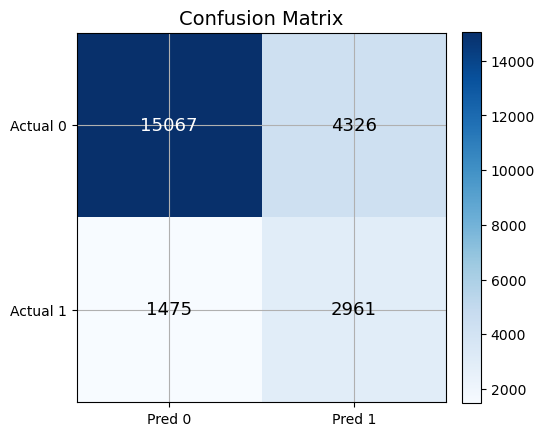

In [78]:
# === Standalone readable CM heatmap ===
cm = confusion_matrix(y_test, final_preds)
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', aspect='equal')
ax.set_title('Confusion Matrix', fontsize=14)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Pred 0','Pred 1'])
ax.set_yticklabels(['Actual 0','Actual 1'])
for (i, j), v in np.ndenumerate(cm):
    color = 'white' if v > cm.max()/2 else 'black'
    ax.text(j, i, f"{v}", ha='center', va='center', fontsize=13, color=color)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.savefig('confusion_matrix_readable.png', dpi=150, bbox_inches='tight'); plt.show()


#### Risk stratification by combinations of factors

In [79]:
test_cov = df.loc[X_test.index].copy()                 # raw covariates for the same rows
test_cov['actual'] = y_test.values
test_cov['predicted_proba'] = proba                    # from best model
test_cov['predicted_label'] = final_preds
test_cov['weight'] = w_test

def wmean(x, w):
    x = np.asarray(x); w = np.asarray(w)
    return (x * w).sum() / (w.sum() + 1e-12)

In [80]:
# === Robust combo risk table (auto-picks existing columns) ===
def wmean(x, w):
    x = np.asarray(x); w = np.asarray(w)
    return (x * w).sum() / (w.sum() + 1e-12)

# Rebuild test_cov if needed (raw covariates + preds + weights)
test_cov = df.loc[X_test.index].copy()
test_cov['actual'] = y_test.values
test_cov['predicted_proba'] = final_proba
test_cov['predicted_label'] = final_preds
test_cov['weight'] = w_test

# Candidate names across common BCSC variants — adjust if you know yours exactly
CANDIDATES = [
     "year",
    "age",
    "race",
    "family_history",
    "first_birth",
    "hormone_therapy",
    "menopause",
    "age_proxy",
    "bmi_proxy",
    "is_bmi_missing",
    "biopsy_yes",
    "biopsy",
    "biopsy_unk",            # 1–13 (older -> higher)
    "menarche",                   # 0=>14,1=12–13,2=<12  (younger -> higher)               # 0:<20,1:20–24,2:25–29,3:≥30,4:nulliparous
    "breast",          # 1–4 (denser -> higher)
    "bmi"                       # 0/1
] 

available = [c for c in CANDIDATES if c in test_cov.columns]

# Pick up to 5 of the most relevant available columns
priority = ["year",
    "age",
    "race",
    "family_history",
    "first_birth",
    "hormone_therapy",
    "menopause",
    "age_proxy",
    "bmi_proxy",
    "is_bmi_missing",
    "biopsy_yes",
    "biopsy",
    "biopsy_unk",            # 1–13 (older -> higher)
    "menarche",                   # 0=>14,1=12–13,2=<12  (younger -> higher)               # 0:<20,1:20–24,2:25–29,3:≥30,4:nulliparous
    "breast",          # 1–4 (denser -> higher)
    "bmi"                       # 0/1
]
use_cols = [c for c in priority if c in available][:5]

print("Using combo columns:", use_cols)
if len(use_cols) < 2:
    print("⚠️ Not enough combo columns found in test_cov. Available:", available)

MIN_ROWS = max(10, int(0.005 * len(test_cov)))  # ~0.5% of test size, at least 10

combo = (test_cov
         .groupby(use_cols, dropna=False)
         .apply(lambda g: pd.Series({
             'n': len(g),
             'n_weighted': g['weight'].sum(),
             'pred_risk_mean': wmean(g['predicted_proba'], g['weight']),
             'obs_rate': wmean(g['actual'], g['weight']),
         }))
         .reset_index())

combo = combo[combo['n'] >= MIN_ROWS].sort_values('pred_risk_mean', ascending=False)
display(combo.head(25))
combo.to_csv('risk_combinations_top.csv', index=False)


Using combo columns: ['year', 'age', 'race', 'family_history', 'first_birth']


Empty DataFrame
Columns: [year, age, race, family_history, first_birth, n, n_weighted, pred_risk_mean, obs_rate]
Index: []

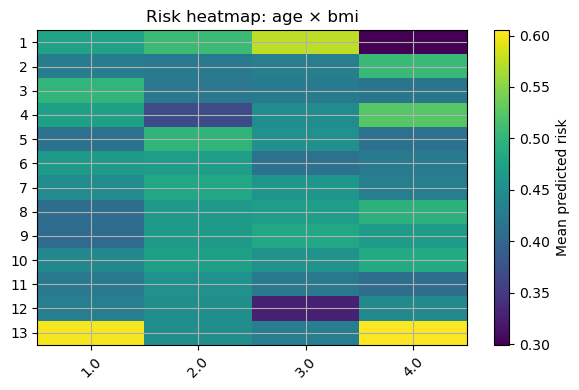

In [81]:
# 2D risk grid (EDIT the pair to match your df)
ROW_COLS = ('age', 'bmi')  # e.g., age group × bmi group

grid = (test_cov
        .groupby(list(ROW_COLS))
        .apply(lambda g: wmean(g['predicted_proba'], g['weight']))
        .unstack(ROW_COLS[1]))

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
im = plt.imshow(grid.values, aspect='auto')
plt.colorbar(label='Mean predicted risk')
plt.xticks(range(len(grid.columns)), list(grid.columns), rotation=45)
plt.yticks(range(len(grid.index)), list(grid.index))
plt.title(f'Risk heatmap: {ROW_COLS[0]} × {ROW_COLS[1]}')
plt.tight_layout()
plt.savefig('risk_heatmap_age_x_bmi.png', dpi=150, bbox_inches='tight')
plt.show()


In [82]:
# Risk decile calibration table
risk_bins = test_cov.copy()
risk_bins['risk_decile'] = pd.qcut(risk_bins['predicted_proba'].rank(method='first'), 10, labels=False) + 1
dec_tbl = (risk_bins
           .groupby('risk_decile')
           .apply(lambda g: pd.Series({
               'n': len(g),
               'n_weighted': g['weight'].sum(),
               'mean_pred': wmean(g['predicted_proba'], g['weight']),
               'obs_rate': wmean(g['actual'], g['weight'])
           }))
           .reset_index()
           .sort_values('risk_decile'))
display(dec_tbl)
dec_tbl.to_csv('risk_deciles.csv', index=False)

risk_decile       n   n_weighted  mean_pred  obs_rate
0            1  2383.0   996.533875   0.086079  0.017004
1            2  2383.0  1966.542368   0.137212  0.017952
2            3  2383.0  2333.854267   0.179803  0.037513
3            4  2383.0  2615.449268   0.233962  0.045622
4            5  2383.0  2835.579450   0.309412  0.096362
5            6  2382.0  2584.474473   0.410907  0.148343
6            7  2383.0  1657.035274   0.531772  0.354937
7            8  2383.0  1838.146983   0.638590  0.453637
8            9  2383.0  2725.319172   0.739164  0.617628
9           10  2383.0  3700.702844   0.855737  0.760868

#### Final calibration graphs

Brier score (lower better): 0.1559


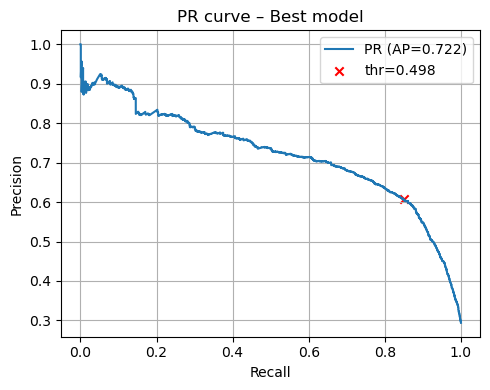

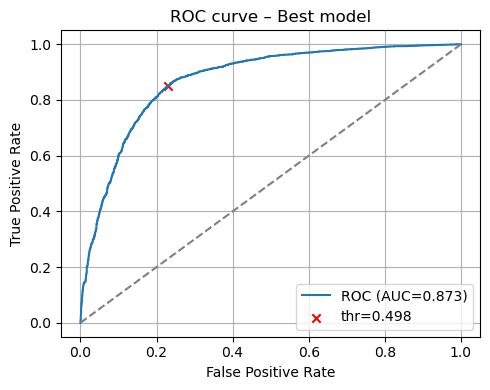

In [83]:
prob_true, prob_pred = calibration_curve(y_test, final_proba, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_test, final_proba, sample_weight=w_test)
print(f"Brier score (lower better): {brier:.4f}")

plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'--', color='grey')
plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted probability (bin mean)")
plt.ylabel("Observed event rate")
plt.title("Reliability diagram – Best model")
plt.tight_layout(); plt.savefig("reliability_diagram.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(5,4))
plt.hist(final_proba, bins=25, edgecolor='k')
plt.xlabel("Predicted probability"); plt.ylabel("Count")
plt.title("Score distribution – Best model")
plt.tight_layout(); plt.savefig("probability_histogram.png", dpi=150, bbox_inches="tight"); plt.show()

P, R, T_pr = precision_recall_curve(y_test, final_proba, sample_weight=w_test)
APw = average_precision_score(y_test, final_proba, sample_weight=w_test)
plt.figure(figsize=(5,4))
plt.plot(R, P, label=f"PR (AP={APw:.3f})")
if len(T_pr) > 0:
    idx_thr = np.argmin(np.abs(T_pr - policy_thr))
    plt.scatter(R[idx_thr], P[idx_thr], color='red', marker='x', label=f"thr={policy_thr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.title("PR curve – Best model")
plt.tight_layout(); plt.savefig("PR_curve_with_threshold.png", dpi=150, bbox_inches="tight"); plt.show()

fpr, tpr, T_roc = roc_curve(y_test, final_proba, sample_weight=w_test)
AUCw = roc_auc_score(y_test, final_proba, sample_weight=w_test)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={AUCw:.3f})")
plt.plot([0,1],[0,1],'--', color='grey')
idx_thr2 = np.argmin(np.abs(T_roc - policy_thr))
plt.scatter(fpr[idx_thr2], tpr[idx_thr2], color='red', marker='x', label=f"thr={policy_thr:.3f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
plt.title("ROC curve – Best model")
plt.tight_layout(); plt.savefig("ROC_curve_with_threshold.png", dpi=150, bbox_inches="tight"); plt.show()

#### Final Model ResultTable

In [84]:
fitted_models = {
    "LogReg": logreg_pipe,
     "RF": RF_best,
     "GB": GB_best,
     "XGB": XGB_best,
    "Ensemble": ens_weighted
}

def weighted_confusion_parts(y, yhat, w):
    w = np.asarray(w) if w is not None else np.ones_like(y, dtype=float)
    y = np.asarray(y); yhat = np.asarray(yhat)
    TP = w[(y==1)&(yhat==1)].sum(); FN = w[(y==1)&(yhat==0)].sum()
    TN = w[(y==0)&(yhat==0)].sum(); FP = w[(y==0)&(yhat==1)].sum()
    return TP, TN, FP, FN

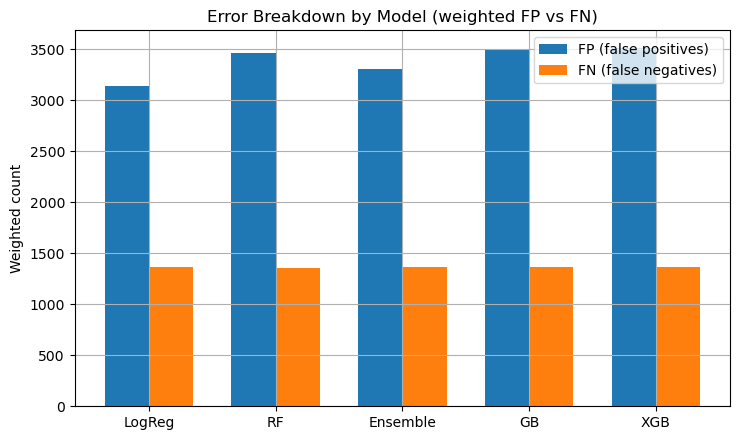

In [85]:
rows = []
for name, mdl in fitted_models.items():
    proba = mdl.predict_proba(X_test)[:,1]
    thrs  = choose_thresholds(y_test, proba, w=w_test, recall_target=0.80)
    thr   = thrs["thr_recallTarget"] if thrs["thr_recallTarget"] is not None else thrs["thr_maxF1"]
    yhat  = (proba >= thr).astype(int)

    TP, TN, FP, FN = weighted_confusion_parts(y_test.values, yhat, w_test)
    EPS=1e-12
    precision = TP/(TP+FP+EPS); recall = TP/(TP+FN+EPS); spec = TN/(TN+FP+EPS)
    acc = (TP+TN)/(TP+TN+FP+FN+EPS); f1 = 2*precision*recall/(precision+recall+EPS)

    apw  = average_precision_score(y_test, proba, sample_weight=w_test)
    aucw = roc_auc_score(y_test, proba, sample_weight=w_test)

    rows.append({
        "Model": name, "Threshold": thr,
        "Precision": precision, "Recall": recall, "Specificity": spec, "Accuracy": acc, "F1": f1,
        "PR_AUC": apw, "ROC_AUC": aucw,
        "TP": TP, "TN": TN, "FP": FP, "FN": FN
    })
    
err_df = pd.DataFrame(rows).sort_values(["PR_AUC","ROC_AUC"], ascending=False)
display(err_df.style.format({
    "Threshold":"{:.3f}","Precision":"{:.3f}","Recall":"{:.3f}",
    "Specificity":"{:.3f}","Accuracy":"{:.3f}","F1":"{:.3f}",
    "PR_AUC":"{:.3f}","ROC_AUC":"{:.3f}",
    "TP":"{:.1f}","TN":"{:.1f}","FP":"{:.1f}","FN":"{:.1f}"
}))


labels = err_df["Model"].tolist()
FPs = err_df["FP"].values
FNs = err_df["FN"].values

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.bar(x - width/2, FPs, width, label='FP (false positives)')
ax.bar(x + width/2, FNs, width, label='FN (false negatives)')
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel("Weighted count")
ax.set_title("Error Breakdown by Model (weighted FP vs FN)")
ax.legend()
plt.tight_layout(); plt.savefig("error_breakdown_fp_fn_by_model.png", dpi=150, bbox_inches="tight"); plt.show()

# --- Optional: stacked bar of correct vs wrong ---
correct = err_df["TP"].values + err_df["TN"].values
wrong   = err_df["FP"].values + err_df["FN"].values

fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.bar(labels, correct, label="Correct", color="#4caf50")
ax.bar(labels, wrong, bottom=correct, label="Wrong", color="#e53935")
ax.set_ylabel("Weighted count")
ax.set_title("Overall Predictions by Model (Correct vs Wrong, weighted)")
ax.legend()
plt.tight_layout(); plt.savefig("error_breakdown_correct_wrong_stacked.png", dpi=150, bbox_inches="tight"); plt.show()

In [86]:
### Saving csv,pkg etc

In [87]:
import json, joblib

# A. final predictions (per-row)
pred_df = pd.DataFrame({
    "index": X_test.index,
    "actual": y_test.values,
    "proba": final_proba,
    "pred": final_preds,
    "weight": w_test
}).set_index("index")
pred_df.to_csv("final_predictions.csv")

# B. metrics at the policy threshold (weighted-only)
best_table, _cm = metrics_row(   # <-- unpack row and confusion matrix
    y_test, final_preds, final_proba, best_name, policy_thr, w_test
)
best_table.to_csv("best_model_metrics.csv", index=False)

# C. risk deciles (weighted)
risk_bins = pred_df.copy()
risk_bins["risk_decile"] = pd.qcut(risk_bins["proba"].rank(method="first"), 10, labels=False) + 1
dec_tbl = (risk_bins
           .groupby("risk_decile")
           .apply(lambda g: pd.Series({
               "n": len(g),
               "n_weighted": g["weight"].sum(),
               "mean_pred": (g["proba"]*g["weight"]).sum()/(g["weight"].sum()+1e-12),
               "obs_rate": (g["actual"]*g["weight"]).sum()/(g["weight"].sum()+1e-12)
           })).reset_index())
dec_tbl.to_csv("risk_deciles.csv", index=False)

# D. combo risk table (only if at least 2 of these exist)
combo_cols = [c for c in ["age_group_5_years","bmi_group","BIRADS_breast_density","menopaus","first_degree_hx","race_eth"]
              if c in X_test.columns][:3]
if len(combo_cols) >= 2:
    tcov = X_test.copy()
    tcov["actual"]=y_test.values; tcov["proba"]=final_proba; tcov["weight"]=w_test
    combo = (tcov.groupby(combo_cols, dropna=False)
             .apply(lambda g: pd.Series({
                 "n": len(g),
                 "n_weighted": g["weight"].sum(),
                 "pred_risk_mean": (g["proba"]*g["weight"]).sum()/(g["weight"].sum()+1e-12),
                 "obs_rate": (g["actual"]*g["weight"]).sum()/(g["weight"].sum()+1e-12)
             })).reset_index().sort_values("pred_risk_mean", ascending=False))
    combo.to_csv("risk_combinations_top.csv", index=False)

# E. store artifacts
artifacts = {
    "best_name": best_name,
    "policy_thr": float(policy_thr),
    "metric_names": list(best_table.columns),
    "combo_cols": combo_cols
}
with open("dashboard_artifacts.json","w") as f:
    json.dump(artifacts, f, indent=2)

# F. optional: save the best model
joblib.dump(best_clf, "best_model.pkl")


['best_model.pkl']